# **Projet NF26 - Estimation du BGES d'une organisation**

## **0 - Préliminaire**

Notre travail préliminaire se compose des étapes suivantes :
- Mettre en place l’environnement d’exécution du programme.
- Extraire les données à partir du fichier compressé.
- Charger les modules et bibliothèques requis.

In [1]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [2]:
# ---------- Bibliothèques standard ---------- #
import os  # Importation standard sans alias

from collections import defaultdict  # Importation sélective de classes sans alias
from datetime import date
from functools import reduce  # Importation sélective de fonctions sans alias

# ---------- Bibliothèques tierces ---------- #
# Importation standard sans alias
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import folium

# Importation sélective de classes sans alias
from geopy.geocoders import Nominatim
from geopy.location import Location
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Importation sélective de modules avec alias
from pyspark.sql import functions as spark_funcs
from pyspark.sql import types as spark_types
import matplotlib.dates as mdates

# Importation sélective de classes avec alias
from pyspark.sql import Column as SparkColumn
from pyspark.sql import Row as SparkRow
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql import Window as SparkWindow
from pyspark.sql.functions import col, split, lower, regexp_replace, month, year, sum as Fsum

# Importation spécifique à Jupyter
from IPython.display import display

# ---------- Modules Python personnalisés ---------- #
from src import utils

import pandas as pd
import numpy as np
from datetime import datetime, date

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import Row

In [3]:
spark = SparkSession.builder.getOrCreate()

25/05/19 22:51:11 WARN Utils: Your hostname, zangziyuandeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.31.113 instead (on interface en0)
25/05/19 22:51:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/19 22:51:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## **1 - Lecture des données**

### materiel _ inpacts

In [4]:
psdf_it_impacts= ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/materiel_informatique_impact.csv', sep=',') 
sdf_it_impacts = psdf_it_impacts.to_spark()
sdf_it_impacts.show(5) 

+------------------+-----------------+------+
|              Type|           Modèle|Impact|
+------------------+-----------------+------+
|PC fixe sans ecran|modèle par défaut|   350|
|PC fixe sans ecran|   Optiplex micro|   174|
|PC fixe sans ecran|   Optiplex small|   240|
|PC fixe sans ecran|   Optiplex tower|   260|
|PC fixe sans ecran| Wyse thin client|    69|
+------------------+-----------------+------+
only showing top 5 rows



/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


### Lecture de Paris

In [5]:
psdf_person_paris=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_PARIS/PERSONNEL_PARIS.txt', sep=';')
psdf_person_paris.head(5)
#psdf_person_paris.shape[0]  :5000

,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DT_NAISS,VILLE_NAISS,PAYS_NAISS,NUM_SECU,IND_PAYS_NUM_TELP,NUM_TELEPHONE,NUM_VOIE,DSC_VOIE,CMPL_VOIE,CD_POSTAL,VILLE,PAYS,FONCTION_PERSONNEL,TS_CREATION_PERSONNEL,TS_MAJ_PPERSONNEL
0,KeyPers_Paris_1230000,Name0,FistName0,1992-03-13,Lille,France,NS000000000,None,+336##0151713,22,NomVoie100,None,#9423,Paris,France,Ingénieur Informaticien,2005-06-24 06:48:21,2005-06-24 06:48:21
1,KeyPers_Paris_1230001,Name1,FistName1,1955-02-17,Pekin,China,NS000000001,None,+336##0797149,33,NomVoie731,None,#2429,Paris,France,Ingénieur Data,2007-11-16 22:38:43,2007-11-16 22:38:43
2,KeyPers_Paris_1230002,Name2,FistName2,1982-10-06,Alger,Algeria,NS000000002,None,+336##0319378,55,NomVoie622,None,#7861,Paris,France,Ingénieur Informaticien,2004-07-09 14:25:16,2004-07-09 14:25:16
3,KeyPers_Paris_1230003,Name3,FistName3,1955-08-22,Lima,Peru,NS000000003,None,+336##0205027,61,NomVoie363,None,#4028,Paris,France,Ingénieur Data,2013-02-16 23:23:05,2013-02-16 23:23:05
4,KeyPers_Paris_1230004,Name4,FistName4,2017-04-07,Pekin,China,NS000000004,None,+336##0456031,68,NomVoie914,None,#0111,Paris,France,Cadre,2001-10-13 22:42:51,2001-10-13 22:42:51


In [6]:
psdf_informatique_paris=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_PARIS/BDD_BGES_PARIS_INFORMATIQUE', sep=';')
psdf_informatique_paris.head(5)
#psdf_informatique_paris.shape[0]  :1545

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MATERIELINFO,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_ACHAT,TYPE,MODELE
0,Paris_MATERIEL_INFO_202406250,KeyPers_Paris_1233515,Name3515,FistName3515,2024-06-25 11:37:24,Ecran,modèle par défaut
1,Paris_MATERIEL_INFO_202406251,KeyPers_Paris_1232092,Name2092,FistName2092,2024-06-25 10:48:59,Vidéo projecteur,modèle par défaut
2,Paris_MATERIEL_INFO_202406252,KeyPers_Paris_1231450,Name1450,FistName1450,2024-06-25 10:52:46,PC fixe sans ecran,"Elite (Tower, SFF, One)"
3,Paris_MATERIEL_INFO_202406253,KeyPers_Paris_1234268,Name4268,FistName4268,2024-06-25 11:55:34,imprimante,Laser A3 (40-99kg)
4,Paris_MATERIEL_INFO_202406254,KeyPers_Paris_1230872,Name872,FistName872,2024-06-25 16:44:37,PC portable,Moyenne 14/15pouces


In [7]:
psdf_mission_paris=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_PARIS/BDD_BGES_PARIS_MISSION', sep=';')
psdf_mission_paris.head(5)
#psdf_mission_paris.shape[0]  :4518

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MISSION,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_MISSION,TYPE_MISSION,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR
0,Paris_202405180,KeyPers_Paris_1233185,Name3185,FistName3185,2024-05-18 23:19:11,Réunion,Paris,France,Wellington,New Zealand,Avion,oui
1,Paris_202405181,KeyPers_Paris_1230183,Name183,FistName183,2024-05-18 10:54:36,Développement,Paris,France,Sidney,Australia,Avion,oui
2,Paris_202405182,KeyPers_Paris_1232953,Name2953,FistName2953,2024-05-18 06:43:42,Développement,Paris,France,Auckland,New Zealand,Avion,oui
3,Paris_202405183,KeyPers_Paris_1234798,Name4798,FistName4798,2024-05-18 22:28:46,Conférence,Paris,France,Oslo,Norvège,Avion,non
4,Paris_202405184,KeyPers_Paris_1231863,Name1863,FistName1863,2024-05-18 04:16:39,Rencontre entreprises,Paris,France,Lima,Peru,Avion,oui


### Lecture de Shanghai


In [8]:
psdf_person_shanghai=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_SHANGHAI/PERSONNEL_SHANGHAI.txt', sep=';')
psdf_person_shanghai.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DT_NAISS,VILLE_NAISS,PAYS_NAISS,NUM_SECU,IND_PAYS_NUM_TELP,NUM_TELEPHONE,NUM_VOIE,DSC_VOIE,CMPL_VOIE,CD_POSTAL,VILLE,PAYS,FONCTION_PERSONNEL,TS_CREATION_PERSONNEL,TS_MAJ_PPERSONNEL
0,KeyPers_Shanghai_1230000,Name0,FistName0,2001-05-14,Rio de Janeiro,Brazil,NS000000000,None,+336##0481414,86,NomVoie440,None,#4474,Shanghai,China,Business Executive,2015-07-07 10:18:57,2015-07-07 10:18:57
1,KeyPers_Shanghai_1230001,Name1,FistName1,1995-06-01,Compiègne,France,NS000000001,None,+336##0648537,86,NomVoie661,None,#3428,Shanghai,China,Data Engineer,2015-02-14 08:32:07,2015-02-14 08:32:07
2,KeyPers_Shanghai_1230002,Name2,FistName2,1983-06-24,Compiègne,France,NS000000002,None,+336##0641720,60,NomVoie722,None,#2672,Shanghai,China,Computer Engineer,2011-03-24 21:17:01,2011-03-24 21:17:01
3,KeyPers_Shanghai_1230003,Name3,FistName3,1963-05-11,Shanghai,China,NS000000003,None,+336##0405078,43,NomVoie773,None,#5575,Shanghai,China,Data Engineer,2013-02-26 20:56:07,2013-02-26 20:56:07
4,KeyPers_Shanghai_1230004,Name4,FistName4,1988-10-08,Vancouver,Canada,NS000000004,None,+336##0899659,94,NomVoie594,None,#7804,Shanghai,China,Data Engineer,2004-08-18 06:54:54,2004-08-18 06:54:54


In [9]:
psdf_informatique_shanghai=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_SHANGHAI/BDD_BGES_SHANGHAI_INFORMATIQUE', sep=';')
psdf_informatique_shanghai.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MATERIELINFO,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_ACHAT,TYPE,MODELE
0,Shanghai_MATERIEL_INFO_202409200,KeyPers_Shanghai_1230677,Name677,FistName677,2024-09-20 13:48:41,PC portable,modèle par défaut
1,Shanghai_MATERIEL_INFO_202409201,KeyPers_Shanghai_1230621,Name621,FistName621,2024-09-20 08:39:31,PC fixe sans ecran,modèle par défaut
2,Shanghai_MATERIEL_INFO_202409202,KeyPers_Shanghai_1230799,Name799,FistName799,2024-09-20 15:09:36,Vidéo projecteur,Pour salle
3,Shanghai_MATERIEL_INFO_202409203,KeyPers_Shanghai_1230479,Name479,FistName479,2024-09-20 15:02:34,PC portable,EliteBook 6xx
4,Shanghai_MATERIEL_INFO_202409204,KeyPers_Shanghai_1230452,Name452,FistName452,2024-09-20 13:19:18,,modèle par défaut


In [10]:
psdf_mission_shanghai=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_SHANGHAI/BDD_BGES_SHANGHAI_MISSION', sep=';')
psdf_mission_shanghai.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MISSION,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_MISSION,TYPE_MISSION,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR
0,Shanghai_202406050,KeyPers_Shanghai_1230528,Name528,FistName528,2024-06-05 15:10:01,Development,Shanghai,China,Los Angeles,USA,Avion,oui
1,Shanghai_202406051,KeyPers_Shanghai_1230794,Name794,FistName794,2024-06-05 08:12:49,Vocational Training,Shanghai,China,Dubaï,Emirats,Avion,oui
2,Shanghai_202406052,KeyPers_Shanghai_1230681,Name681,FistName681,2024-06-05 09:43:46,Development,Shanghai,China,Pekin,China,Train,oui
3,Shanghai_202406053,KeyPers_Shanghai_1230807,Name807,FistName807,2024-06-05 15:55:40,Vocational Training,Shanghai,China,Marseille,France,Avion,oui
4,Shanghai_202406054,KeyPers_Shanghai_1230435,Name435,FistName435,2024-06-05 11:04:37,Conference,Shanghai,China,Alger,Algeria,Avion,non


### Lecture de berln

In [11]:
psdf_person_berlin=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_BERLIN/PERSONNEL_BERLIN.txt', sep=';')
psdf_person_berlin.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DT_NAISS,VILLE_NAISS,PAYS_NAISS,NUM_SECU,IND_PAYS_NUM_TELP,NUM_TELEPHONE,NUM_VOIE,DSC_VOIE,CMPL_VOIE,CD_POSTAL,VILLE,PAYS,FONCTION_PERSONNEL,TS_CREATION_PERSONNEL,TS_MAJ_PPERSONNEL
0,KeyPers_Berlin_1230000,Name0,FistName0,1993-11-04,Osaka,Japan,NS000000000,None,+336##0263188,57,NomVoie940,None,#8830,Berlin,Germany,Dateningenieur,2010-09-09 11:22:17,2010-09-09 11:22:17
1,KeyPers_Berlin_1230001,Name1,FistName1,1932-11-22,Wellington,New Zealand,NS000000001,None,+336##0401873,64,NomVoie711,None,#9785,Berlin,Germany,Führungskraft,2017-07-24 16:51:18,2017-07-24 16:51:18
2,KeyPers_Berlin_1230002,Name2,FistName2,1990-08-12,Sidney,Australia,NS000000002,None,+336##0524126,94,NomVoie322,None,#4816,Berlin,Germany,Dateningenieur,1997-08-20 04:01:46,1997-08-20 04:01:46
3,KeyPers_Berlin_1230003,Name3,FistName3,1965-05-26,Rabat,Maroc,NS000000003,None,+336##0418484,78,NomVoie593,None,#3546,Berlin,Germany,Ökonom,1998-11-17 19:25:01,1998-11-17 19:25:01
4,KeyPers_Berlin_1230004,Name4,FistName4,1959-01-18,Shanghai,China,NS000000004,None,+336##0986317,65,NomVoie404,None,#6788,Berlin,Germany,Dateningenieur,2010-11-10 04:24:37,2010-11-10 04:24:37


In [12]:
psdf_informatique_berlin=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_BERLIN/BDD_BGES_BERLIN_INFORMATIQUE', sep=';')
psdf_informatique_berlin.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MATERIELINFO,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_ACHAT,TYPE,MODELE
0,BERLIN_MATERIEL_INFO_202411050,KeyPers_Berlin_1233545,Name3545,FistName3545,2024-11-05 12:14:51,PC fixe sans ecran,"Elite (Tower, SFF, One)"
1,BERLIN_MATERIEL_INFO_202411051,KeyPers_Berlin_1233662,Name3662,FistName3662,2024-11-05 16:09:40,Serveur,Modèle par défaut
2,BERLIN_MATERIEL_INFO_202411052,KeyPers_Berlin_1231784,Name1784,FistName1784,2024-11-05 15:46:01,souris,modèle par défaut
3,BERLIN_MATERIEL_INFO_202411053,KeyPers_Berlin_1230638,Name638,FistName638,2024-11-05 10:21:49,PC fixe sans ecran,Precision tower 5xxx
4,BERLIN_MATERIEL_INFO_202411054,KeyPers_Berlin_1233852,Name3852,FistName3852,2024-11-05 16:47:30,PC fixe sans ecran,ZHAN


In [13]:
psdf_mission_berlin=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_BERLIN/BDD_BGES_BERLIN_MISSION', sep=';')
psdf_mission_berlin.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MISSION,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_MISSION,TYPE_MISSION,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR
0,BERLIN_202411110,KeyPers_Berlin_1230238,Name238,FistName238,2024-11-11 13:34:45,Schulung,Berlin,Allemagne,Buenos Aires,Argentina,Avion,oui
1,BERLIN_202411111,KeyPers_Berlin_1230352,Name352,FistName352,2024-11-11 03:42:11,Schulung,Berlin,Allemagne,Berlin,Allemagne,Transports en commun,oui
2,BERLIN_202411112,KeyPers_Berlin_1233087,Name3087,FistName3087,2024-11-11 18:32:48,Entwicklung,New-York,USA,Vancouver,Canada,Avion,oui
3,BERLIN_202411113,KeyPers_Berlin_1234060,Name4060,FistName4060,2024-11-11 22:06:55,Entwicklung,Paris,France,Tokyo,Japan,Avion,oui
4,BERLIN_202411114,KeyPers_Berlin_1233427,Name3427,FistName3427,2024-11-11 02:12:52,Geschäftstreffen,Berlin,Allemagne,Los Angeles,USA,Avion,oui


### Lecture de London

In [14]:
psdf_person_london=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_LONDON/PERSONNEL_LONDON.txt', sep=';')
psdf_person_london.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DT_NAISS,VILLE_NAISS,PAYS_NAISS,NUM_SECU,IND_PAYS_NUM_TELP,NUM_TELEPHONE,NUM_VOIE,DSC_VOIE,CMPL_VOIE,CD_POSTAL,VILLE,PAYS,FONCTION_PERSONNEL,TS_CREATION_PERSONNEL,TS_MAJ_PPERSONNEL
0,KeyPers_London_1230000,Name0,FistName0,2004-07-14,Melbourne,Australia,NS000000000,None,+336##0612365,97,NomVoie120,None,#1819,London,England,Data Engineer,2020-10-03 17:41:19,2020-10-03 17:41:19
1,KeyPers_London_1230001,Name1,FistName1,1954-10-23,Tunis,Tunisie,NS000000001,None,+336##0487142,65,NomVoie351,None,#1748,London,England,Data Engineer,2022-09-09 06:06:04,2022-09-09 06:06:04
2,KeyPers_London_1230002,Name2,FistName2,1937-04-09,Tokyo,Japan,NS000000002,None,+336##0059989,71,NomVoie442,None,#0669,London,England,Computer Engineer,2007-08-27 10:18:05,2007-08-27 10:18:05
3,KeyPers_London_1230003,Name3,FistName3,1970-08-07,Bordeaux,France,NS000000003,None,+336##0366753,10,NomVoie743,None,#9255,London,England,Data Engineer,2023-10-02 21:57:57,2023-10-02 21:57:57
4,KeyPers_London_1230004,Name4,FistName4,1994-11-26,Helsinki,Finlande,NS000000004,None,+336##0422772,47,NomVoie314,None,#7467,London,England,Computer Engineer,2013-01-24 14:22:05,2013-01-24 14:22:05


In [15]:
psdf_informatique_london=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_LONDON/BDD_BGES_LONDON_INFORMATIQUE', sep=';')
psdf_informatique_london.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MATERIELINFO,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_ACHAT,TYPE,MODELE
0,LONDON_MATERIEL_INFO_202410030,KeyPers_London_1231533,Name1533,FistName1533,2024-10-03 16:48:26,,"Prodesk (Tower, SFF)"
1,LONDON_MATERIEL_INFO_202410031,KeyPers_London_1231342,Name1342,FistName1342,2024-10-03 09:05:51,PC portable,ProBook
2,LONDON_MATERIEL_INFO_202410032,KeyPers_London_1232922,Name2922,FistName2922,2024-10-03 15:55:28,PC fixe sans ecran,Wyse thin client
3,LONDON_MATERIEL_INFO_202410033,KeyPers_London_1233394,Name3394,FistName3394,2024-10-03 10:38:04,,Latitude 5xxx
4,LONDON_MATERIEL_INFO_202410034,KeyPers_London_1233566,Name3566,FistName3566,2024-10-03 12:11:29,PC portable,MacBook air pre-retina


In [16]:
psdf_mission_london=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_LONDON/BDD_BGES_LONDON_MISSION', sep=';')
psdf_mission_london.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MISSION,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_MISSION,TYPE_MISSION,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR
0,LONDON_202410190,KeyPers_London_1231718,Name1718,FistName1718,2024-10-19 01:15:13,Vocational Training,London,England,Melbourne,Australia,Avion,non
1,LONDON_202410191,KeyPers_London_1230403,Name403,FistName403,2024-10-19 12:03:35,Development,London,England,Alger,Algeria,Avion,oui
2,LONDON_202410192,KeyPers_London_1233125,Name3125,FistName3125,2024-10-19 03:22:25,Vocational Training,London,England,Montreal,Canada,Avion,oui
3,LONDON_202410193,KeyPers_London_1231247,Name1247,FistName1247,2024-10-19 09:20:18,Team Meeting,London,England,Rabat,Maroc,Avion,oui
4,LONDON_202410194,KeyPers_London_1231939,Name1939,FistName1939,2024-10-19 06:26:02,Development,London,England,Los Angeles,USA,Avion,oui


### Lecture de Lonsangeles

In [17]:
psdf_person_losangeles=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_LOSANGELES/PERSONNEL_LOSANGELES.txt', sep=';')
psdf_person_losangeles.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DT_NAISS,VILLE_NAISS,PAYS_NAISS,NUM_SECU,IND_PAYS_NUM_TELP,NUM_TELEPHONE,NUM_VOIE,DSC_VOIE,CMPL_VOIE,CD_POSTAL,VILLE,PAYS,FONCTION_PERSONNEL,TS_CREATION_PERSONNEL,TS_MAJ_PPERSONNEL
0,KeyPers_LA_1230000,Name0,FistName0,2012-03-20,Compiègne,France,NS000000000,None,+336##0864857,80,NomVoie730,None,#8378,Los Angeles,USA,Business Executive,2011-01-20 04:14:27,2011-01-20 04:14:27
1,KeyPers_LA_1230001,Name1,FistName1,1943-11-04,Auckland,New Zealand,NS000000001,None,+336##0389143,72,NomVoie51,None,#5530,Los Angeles,USA,Data Engineer,2001-04-12 16:39:19,2001-04-12 16:39:19
2,KeyPers_LA_1230002,Name2,FistName2,1993-10-25,Paris,France,NS000000002,None,+336##0553330,6,NomVoie112,None,#5279,Los Angeles,USA,Economist,2010-10-21 15:52:41,2010-10-21 15:52:41
3,KeyPers_LA_1230003,Name3,FistName3,1983-02-27,Washington,USA,NS000000003,None,+336##0860769,18,NomVoie503,None,#5909,Los Angeles,USA,Data Engineer,2021-08-09 11:11:53,2021-08-09 11:11:53
4,KeyPers_LA_1230004,Name4,FistName4,2013-11-05,London,England,NS000000004,None,+336##0791470,23,NomVoie454,None,#2837,Los Angeles,USA,Data Engineer,2022-05-23 18:50:27,2022-05-23 18:50:27


In [18]:
psdf_informatique_losangeles=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_LOSANGELES/BDD_BGES_LOSANGELES_INFORMATIQUE', sep=';')
psdf_informatique_losangeles.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MATERIELINFO,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_ACHAT,TYPE,MODELE
0,LA_MATERIEL_INFO_202407060,KeyPers_LA_1231978,Name1978,FistName1978,2024-07-06 08:39:05,Vidéo projecteur,modèle par défaut
1,LA_MATERIEL_INFO_202407061,KeyPers_LA_1231609,Name1609,FistName1609,2024-07-06 08:10:36,PC fixe sans ecran,Optiplex small
2,LA_MATERIEL_INFO_202407062,KeyPers_LA_1230112,Name112,FistName112,2024-07-06 13:35:18,imprimante,Laser A3 (>100kg)
3,LA_MATERIEL_INFO_202407063,KeyPers_LA_1232436,Name2436,FistName2436,2024-07-06 15:32:55,Serveur,Modèle par défaut
4,LA_MATERIEL_INFO_202407064,KeyPers_LA_1232904,Name2904,FistName2904,2024-07-06 10:21:24,PC fixe sans ecran,"EliteDesk (Tower, SFF, One)"


In [19]:
psdf_mission_losangeles=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_LOSANGELES/BDD_BGES_LOSANGELES_MISSION', sep=';')
psdf_mission_losangeles.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MISSION,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_MISSION,TYPE_MISSION,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR
0,LA_202405070,KeyPers_LA_1232039,Name2039,FistName2039,2024-05-07 07:03:44,Development,Los Angeles,USA,Lille,France,Avion,oui
1,LA_202405071,KeyPers_LA_1232529,Name2529,FistName2529,2024-05-07 22:57:21,Vocational Training,Los Angeles,USA,Los Angeles,USA,Transports en commun,non
2,LA_202405072,KeyPers_LA_1231329,Name1329,FistName1329,2024-05-07 06:27:09,Conference,Los Angeles,USA,Sao Paulo,Brazil,Avion,oui
3,LA_202405073,KeyPers_LA_1230475,Name475,FistName475,2024-05-07 12:06:31,Team Meeting,Paris,France,Bogota,Colombia,Avion,oui
4,LA_202405074,KeyPers_LA_1230188,Name188,FistName188,2024-05-07 19:41:53,Conference,New-York,USA,Rabat,Maroc,Avion,oui


### Lecture de Newyork

In [20]:
psdf_person_newyork=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_NEWYORK/PERSONNEL_NEWYORK.txt', sep=';')
psdf_person_newyork.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DT_NAISS,VILLE_NAISS,PAYS_NAISS,NUM_SECU,IND_PAYS_NUM_TELP,NUM_TELEPHONE,NUM_VOIE,DSC_VOIE,CMPL_VOIE,CD_POSTAL,VILLE,PAYS,FONCTION_PERSONNEL,TS_CREATION_PERSONNEL,TS_MAJ_PPERSONNEL
0,KeyPers_NewYork_1230000,Name0,FistName0,2011-06-01,Tokyo,Japan,NS000000000,None,+336##0264749,33,NomVoie790,None,#9358,New-York,USA,Business Executive,2021-07-10 15:48:40,2021-07-10 15:48:40
1,KeyPers_NewYork_1230001,Name1,FistName1,1995-04-10,Oslo,Norvège,NS000000001,None,+336##0035150,94,NomVoie871,None,#1775,New-York,USA,Computer Engineer,2013-11-04 14:06:40,2013-11-04 14:06:40
2,KeyPers_NewYork_1230002,Name2,FistName2,1963-04-24,Stockholm,Suède,NS000000002,None,+336##0076311,31,NomVoie472,None,#4431,New-York,USA,Computer Engineer,2020-10-20 11:36:07,2020-10-20 11:36:07
3,KeyPers_NewYork_1230003,Name3,FistName3,1977-09-03,Osaka,Japan,NS000000003,None,+336##0151475,41,NomVoie593,None,#9525,New-York,USA,Data Engineer,2012-10-27 03:07:45,2012-10-27 03:07:45
4,KeyPers_NewYork_1230004,Name4,FistName4,1950-06-17,Mexico,Mexico,NS000000004,None,+336##0394564,0,NomVoie794,None,#3464,New-York,USA,Computer Engineer,2019-03-21 11:07:16,2019-03-21 11:07:16


In [21]:
psdf_informatique_newyork=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_NEWYORK/BDD_BGES_NEWYORK_INFORMATIQUE', sep=';')
psdf_informatique_newyork.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MATERIELINFO,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_ACHAT,TYPE,MODELE
0,NewYork_MATERIEL_INFO_202406250,KeyPers_NewYork_1231314,Name1314,FistName1314,2024-06-25 09:01:53,PC fixe sans ecran,Station de travail (moy)
1,NewYork_MATERIEL_INFO_202406251,KeyPers_NewYork_1231458,Name1458,FistName1458,2024-06-25 09:41:42,Station d'accueil,modèle par défaut
2,NewYork_MATERIEL_INFO_202406252,KeyPers_NewYork_1231652,Name1652,FistName1652,2024-06-25 15:21:36,PC fixe tout-en-un,Mac pro
3,NewYork_MATERIEL_INFO_202406253,KeyPers_NewYork_1231180,Name1180,FistName1180,2024-06-25 08:28:16,PC fixe sans ecran,Precision tower 3xxx
4,NewYork_MATERIEL_INFO_202406254,KeyPers_NewYork_1230731,Name731,FistName731,2024-06-25 14:04:36,PC fixe sans ecran,Wyse thin client


In [22]:
psdf_mission_newyork=ps.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/BDD_BGES/BDD_BGES_NEWYORK/BDD_BGES_NEWYORK_MISSION', sep=';')
psdf_mission_newyork.head(5)

/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,ID_MISSION,ID_PERSONNEL,NOM_PERSONNEL,PRENOM_PERSONNEL,DATE_MISSION,TYPE_MISSION,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR
0,NewYork_202405010,KeyPers_NewYork_1230589,Name589,FistName589,2024-05-01 02:03:41,Conference,New-York,USA,Auckland,New Zealand,Avion,oui
1,NewYork_202405011,KeyPers_NewYork_1231060,Name1060,FistName1060,2024-05-01 21:53:59,Business Meeting,New-York,USA,Tunis,Tunisie,Avion,oui
2,NewYork_202405012,KeyPers_NewYork_1230977,Name977,FistName977,2024-05-01 02:25:02,Vocational Training,New-York,USA,Sao Paulo,Brazil,Avion,oui
3,NewYork_202405013,KeyPers_NewYork_1230284,Name284,FistName284,2024-05-01 05:31:53,Business Meeting,New-York,USA,Pekin,China,Avion,oui
4,NewYork_202405014,KeyPers_NewYork_1232661,Name2661,FistName2661,2024-05-01 05:55:53,Team Meeting,New-York,USA,London,England,Avion,oui


## Conversion en données de classe Spark

In [23]:

sdf_person_paris=psdf_person_paris.to_spark()
sdf_informatique_paris=psdf_informatique_paris.to_spark()
sdf_mission_paris=psdf_mission_paris.to_spark()

sdf_person_shanghai=psdf_person_shanghai.to_spark()
sdf_informatique_shanghai=psdf_informatique_shanghai.to_spark()
sdf_mission_shanghai=psdf_mission_shanghai.to_spark()

sdf_person_berlin=psdf_person_berlin.to_spark()
sdf_informatique_berlin=psdf_informatique_berlin.to_spark()
sdf_mission_berlin=psdf_mission_berlin.to_spark()

sdf_person_london=psdf_person_london.to_spark()
sdf_informatique_london=psdf_informatique_london.to_spark() 
sdf_mission_london=psdf_mission_london.to_spark()

sdf_person_losangeles=psdf_person_losangeles.to_spark()
sdf_informatique_losangeles=psdf_informatique_losangeles.to_spark()
sdf_mission_losangeles=psdf_mission_losangeles.to_spark()

sdf_person_newyork=psdf_person_newyork.to_spark()
sdf_informatique_newyork=psdf_informatique_newyork.to_spark()
sdf_mission_newyork=psdf_mission_newyork.to_spark()



/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


## Traitement des valeurs vides pour les colonnes TYPE et MODELE

In [24]:
import pyspark.pandas as ps
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


psdf_train = ps.concat([
    psdf_informatique_berlin, 
    psdf_informatique_paris, 
    psdf_informatique_london, 
    psdf_informatique_losangeles, 
    psdf_informatique_newyork, 
    psdf_informatique_shanghai
], axis=0)


psdf_train = psdf_train.dropna(subset=["TYPE", "MODELE"])


X_type_train = psdf_train["MODELE"].to_pandas()
y_type_train = psdf_train["TYPE"].to_pandas()

X_model_train = psdf_train["TYPE"].to_pandas()
y_model_train = psdf_train["MODELE"].to_pandas()


type_vectorizer = CountVectorizer().fit(X_type_train)
model_vectorizer = CountVectorizer().fit(X_model_train)

type_classifier = MultinomialNB().fit(type_vectorizer.transform(X_type_train), y_type_train)
model_classifier = MultinomialNB().fit(model_vectorizer.transform(X_model_train), y_model_train)




/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/opt/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [25]:

def fill_missing_values(df, type_classifier, type_vectorizer, model_classifier, model_vectorizer):
   
    df = df.toPandas()

    typeindextopredict = df[(df['TYPE'].isnull()) | (df['TYPE'].str.strip() == "")].index
    typetopredict = df.loc[typeindextopredict, 'MODELE']

    if not typetopredict.empty:
        print(f"PREDICTING {len(typetopredict)} TYPE...")
        predicted_types = type_classifier.predict(type_vectorizer.transform(typetopredict))
        df.loc[typeindextopredict, 'TYPE'] = predicted_types
    else:
        print("NO NULL TYPE")

    modelindextopredict = df[(df['MODELE'].isnull()) | (df['MODELE'].str.strip() == "")].index
    modeltopredict = df.loc[modelindextopredict, 'TYPE']

    if not modeltopredict.empty:
        print(f"PREDICTING {len(modeltopredict)} MODEL...")
        predicted_models = model_classifier.predict(model_vectorizer.transform(modeltopredict))
        df.loc[modelindextopredict, 'MODELE'] = predicted_models
    else:
        print("NO NULL MODEL")

    return spark.createDataFrame(df)

sdf_list = [
    sdf_informatique_paris,
    sdf_informatique_berlin,
    sdf_informatique_london,
    sdf_informatique_losangeles,
    sdf_informatique_newyork,
    sdf_informatique_shanghai
]

sdf_names = [
    "sdf_informatique_paris",
    "sdf_informatique_berlin",
    "sdf_informatique_london",
    "sdf_informatique_losangeles",
    "sdf_informatique_newyork",
    "sdf_informatique_shanghai"
]

for i, sdf in enumerate(sdf_list):
    print(f"\nProcessing {sdf_names[i]}...")
    globals()[sdf_names[i]] = fill_missing_values(
        sdf, type_classifier, type_vectorizer, model_classifier, model_vectorizer
    )

print("\n finish ")






Processing sdf_informatique_paris...
PREDICTING 327 TYPE...
PREDICTING 131 MODEL...

Processing sdf_informatique_berlin...
PREDICTING 126 TYPE...
PREDICTING 53 MODEL...

Processing sdf_informatique_london...
PREDICTING 296 TYPE...
PREDICTING 109 MODEL...

Processing sdf_informatique_losangeles...
PREDICTING 274 TYPE...
PREDICTING 120 MODEL...

Processing sdf_informatique_newyork...
PREDICTING 293 TYPE...
PREDICTING 115 MODEL...

Processing sdf_informatique_shanghai...
PREDICTING 322 TYPE...
PREDICTING 116 MODEL...

 finish 


In [26]:
sdf_informatique_paris.select("TYPE").distinct().show()

+------------------+
|              TYPE|
+------------------+
|           clavier|
|  Vidéo projecteur|
|          Tablette|
|            souris|
|      Telephone IP|
|PC fixe sans ecran|
|        imprimante|
|       PC portable|
|           Serveur|
|        Disque dur|
| Station d'accueil|
|        Smartphone|
|PC fixe tout-en-un|
|             Ecran|
|        Borne wifi|
+------------------+



## **ETL_person  Unification des différentes langues**

In [27]:
sdf_person_paris.show(2)
print('before replace')
sdf_person_paris_1=sdf_person_paris.select(sdf_person_paris.FONCTION_PERSONNEL).distinct().show()
sdf_person_paris=sdf_person_paris.replace({'Ingénieur Data':'Data Engineer','Economiste':'Economist','DRH':'HRD','Ingénieur Informaticien':'Computer Engineer','Cadre':'Business Executive'},subset=['FONCTION_PERSONNEL'])
print('after replace')
sdf_person_paris_1=sdf_person_paris.select(sdf_person_paris.FONCTION_PERSONNEL).distinct().show()

+--------------------+-------------+----------------+----------+-----------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+-----+------+--------------------+---------------------+-------------------+
|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|VILLE_NAISS|PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL|VILLE|  PAYS|  FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+--------------------+-------------+----------------+----------+-----------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+-----+------+--------------------+---------------------+-------------------+
|KeyPers_Paris_123...|        Name0|       FistName0|1992-03-13|      Lille|    France|NS000000000|             NULL|+336##0151713|      22|NomVoie100|     NULL|    #9423|Paris|France|Ingénieur Informa...|  2005-06-24 06:48:21|2005-06-24 06:48:21|
|KeyPers

In [28]:
sdf_person_shanghai.show(3)
sdf_person_shanghai_1=sdf_person_shanghai.select(sdf_person_shanghai.FONCTION_PERSONNEL).distinct().show(20)
print('no need to replace')


+--------------------+-------------+----------------+----------+--------------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+--------+-----+------------------+---------------------+-------------------+
|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|   VILLE_NAISS|PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL|   VILLE| PAYS|FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+--------------------+-------------+----------------+----------+--------------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+--------+-----+------------------+---------------------+-------------------+
|KeyPers_Shanghai_...|        Name0|       FistName0|2001-05-14|Rio de Janeiro|    Brazil|NS000000000|             NULL|+336##0481414|      86|NomVoie440|     NULL|    #4474|Shanghai|China|Business Executive|  2015-07-07 10:18:57|2015-07-07 10:18:

In [29]:
sdf_person_berlin.show(3)
print('before replace ')
sdf_person_berlin.select("FONCTION_PERSONNEL").distinct().show()

sdf_person_berlin = sdf_person_berlin.replace(
    {
        'Dateningenieur': 'Data Engineer',
        'Ökonom': 'Economist',
        'Personalleiter': 'HRD',
        'Computeringenieur': 'Computer Engineer',
        'Führungskraft': 'Business Executive'
    },
    subset=['FONCTION_PERSONNEL']
)

print('after replace ：')
sdf_person_berlin.select("FONCTION_PERSONNEL").distinct().show()

+--------------------+-------------+----------------+----------+-----------+-----------+-----------+-----------------+-------------+--------+----------+---------+---------+------+-------+------------------+---------------------+-------------------+
|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|VILLE_NAISS| PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL| VILLE|   PAYS|FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+--------------------+-------------+----------------+----------+-----------+-----------+-----------+-----------------+-------------+--------+----------+---------+---------+------+-------+------------------+---------------------+-------------------+
|KeyPers_Berlin_12...|        Name0|       FistName0|1993-11-04|      Osaka|      Japan|NS000000000|             NULL|+336##0263188|      57|NomVoie940|     NULL|    #8830|Berlin|Germany|    Dateningenieur|  2010-09-09 11:22:17|2010-09-09 11:22:17|
|Key

In [30]:
sdf_person_london.show(3)
sdf_person_london_1=sdf_person_london.select(sdf_person_london.FONCTION_PERSONNEL).distinct().show(20)
print('no need to replace')

+--------------------+-------------+----------------+----------+-----------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+------+-------+------------------+---------------------+-------------------+
|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|VILLE_NAISS|PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL| VILLE|   PAYS|FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+--------------------+-------------+----------------+----------+-----------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+------+-------+------------------+---------------------+-------------------+
|KeyPers_London_12...|        Name0|       FistName0|2004-07-14|  Melbourne| Australia|NS000000000|             NULL|+336##0612365|      97|NomVoie120|     NULL|    #1819|London|England|     Data Engineer|  2020-10-03 17:41:19|2020-10-03 17:41:19|
|KeyPers

In [31]:
sdf_person_losangeles.show(3)
sdf_person_losangeles_1=sdf_person_losangeles.select(sdf_person_losangeles.FONCTION_PERSONNEL).distinct().show(20)
print('no need to replace')

+------------------+-------------+----------------+----------+-----------+-----------+-----------+-----------------+-------------+--------+----------+---------+---------+-----------+----+------------------+---------------------+-------------------+
|      ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|VILLE_NAISS| PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL|      VILLE|PAYS|FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+------------------+-------------+----------------+----------+-----------+-----------+-----------+-----------------+-------------+--------+----------+---------+---------+-----------+----+------------------+---------------------+-------------------+
|KeyPers_LA_1230000|        Name0|       FistName0|2012-03-20|  Compiègne|     France|NS000000000|             NULL|+336##0864857|      80|NomVoie730|     NULL|    #8378|Los Angeles| USA|Business Executive|  2011-01-20 04:14:27|2011-01-20 04:14:27|
|Key

In [32]:
sdf_person_newyork.show(3)
sdf_person_newyork_1=sdf_person_newyork.select(sdf_person_newyork.FONCTION_PERSONNEL).distinct().show(20)
print('no need to replace')

+--------------------+-------------+----------------+----------+-----------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+--------+----+------------------+---------------------+-------------------+
|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|VILLE_NAISS|PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL|   VILLE|PAYS|FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+--------------------+-------------+----------------+----------+-----------+----------+-----------+-----------------+-------------+--------+----------+---------+---------+--------+----+------------------+---------------------+-------------------+
|KeyPers_NewYork_1...|        Name0|       FistName0|2011-06-01|      Tokyo|     Japan|NS000000000|             NULL|+336##0264749|      33|NomVoie790|     NULL|    #9358|New-York| USA|Business Executive|  2021-07-10 15:48:40|2021-07-10 15:48:40|
|KeyPers_New

## **ETL_MISSION   Unification des différentes langues**

In [33]:
sdf_mission_paris.show(3)
print('before replace')
sdf_mission_paris_1=sdf_mission_paris.select(sdf_mission_paris.TYPE_MISSION).distinct().show(20)
print('after replace')
sdf_mission_paris=sdf_mission_paris.replace({'Conférence':'Conference','Réunion':'Team Meeting','Développement':'Development','Formation':'Vocational Training','Rencontre entreprises':'Business Meeting'},subset=['TYPE_MISSION'])
sdf_mission_paris.select(sdf_mission_paris.TYPE_MISSION).distinct().show(20)

+---------------+--------------------+-------------+----------------+-------------------+-------------+------------+-----------+-----------------+----------------+---------+------------+
|     ID_MISSION|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|       DATE_MISSION| TYPE_MISSION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|ALLER_RETOUR|
+---------------+--------------------+-------------+----------------+-------------------+-------------+------------+-----------+-----------------+----------------+---------+------------+
|Paris_202405180|KeyPers_Paris_123...|     Name3185|    FistName3185|2024-05-18 23:19:11|      Réunion|       Paris|     France|       Wellington|     New Zealand|    Avion|         oui|
|Paris_202405181|KeyPers_Paris_123...|      Name183|     FistName183|2024-05-18 10:54:36|Développement|       Paris|     France|           Sidney|       Australia|    Avion|         oui|
|Paris_202405182|KeyPers_Paris_123...|     Name2953|    FistName2

In [34]:
sdf_mission_shanghai.show(3)
sdf_mission_shanghai_1=sdf_mission_shanghai.select(sdf_mission_shanghai.TYPE_MISSION).distinct().show(20)
print('no need to replace')

+------------------+--------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------+
|        ID_MISSION|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|       DATE_MISSION|       TYPE_MISSION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|ALLER_RETOUR|
+------------------+--------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------+
|Shanghai_202406050|KeyPers_Shanghai_...|      Name528|     FistName528|2024-06-05 15:10:01|        Development|    Shanghai|      China|      Los Angeles|             USA|    Avion|         oui|
|Shanghai_202406051|KeyPers_Shanghai_...|      Name794|     FistName794|2024-06-05 08:12:49|Vocational Training|    Shanghai|      China|            Dubaï|         Emirats|    Avion|         oui|
|Shanghai_202406052|

In [35]:
sdf_mission_berlin.show(3)
print('before replace')
sdf_mission_berlin_1=sdf_mission_berlin.select(sdf_mission_berlin.TYPE_MISSION).distinct().show(20)
print('after replace')
sdf_mission_berlin=sdf_mission_berlin.replace({'Geschäftstreffen':'Business Meeting','Konferenz':'Conference','Schulung':'Vocational Training','Meeting':'Team Meeting','Entwicklung':'Development'},subset=['TYPE_MISSION'])
sdf_mission_berlin.select(sdf_mission_berlin.TYPE_MISSION).distinct().show()

+----------------+--------------------+-------------+----------------+-------------------+------------+------------+-----------+-----------------+----------------+--------------------+------------+
|      ID_MISSION|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|       DATE_MISSION|TYPE_MISSION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|           TRANSPORT|ALLER_RETOUR|
+----------------+--------------------+-------------+----------------+-------------------+------------+------------+-----------+-----------------+----------------+--------------------+------------+
|BERLIN_202411110|KeyPers_Berlin_12...|      Name238|     FistName238|2024-11-11 13:34:45|    Schulung|      Berlin|  Allemagne|     Buenos Aires|       Argentina|               Avion|         oui|
|BERLIN_202411111|KeyPers_Berlin_12...|      Name352|     FistName352|2024-11-11 03:42:11|    Schulung|      Berlin|  Allemagne|           Berlin|       Allemagne|Transports en commun|         oui|
|BERLIN_20

In [36]:
sdf_mission_london.show(3)
sdf_mission_london_1=sdf_mission_london.select(sdf_mission_london.TYPE_MISSION).distinct().show(20)
print('no need to replace')

+----------------+--------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------+
|      ID_MISSION|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|       DATE_MISSION|       TYPE_MISSION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|ALLER_RETOUR|
+----------------+--------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------+
|LONDON_202410190|KeyPers_London_12...|     Name1718|    FistName1718|2024-10-19 01:15:13|Vocational Training|      London|    England|        Melbourne|       Australia|    Avion|         non|
|LONDON_202410191|KeyPers_London_12...|      Name403|     FistName403|2024-10-19 12:03:35|        Development|      London|    England|            Alger|         Algeria|    Avion|         oui|
|LONDON_202410192|KeyPers_Lond

In [37]:
sdf_mission_losangeles.show(3)
sdf_mission_losangeles_1=sdf_mission_losangeles.select(sdf_mission_losangeles.TYPE_MISSION).distinct().show(20)
print('no need to replace')

+------------+------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+--------------------+------------+
|  ID_MISSION|      ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|       DATE_MISSION|       TYPE_MISSION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|           TRANSPORT|ALLER_RETOUR|
+------------+------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+--------------------+------------+
|LA_202405070|KeyPers_LA_1232039|     Name2039|    FistName2039|2024-05-07 07:03:44|        Development| Los Angeles|        USA|            Lille|          France|               Avion|         oui|
|LA_202405071|KeyPers_LA_1232529|     Name2529|    FistName2529|2024-05-07 22:57:21|Vocational Training| Los Angeles|        USA|      Los Angeles|             USA|Transports en commun|         non|
|LA_2

In [38]:
sdf_mission_newyork.show(3)
sdf_mission_newyork_1=sdf_mission_newyork.select(sdf_mission_newyork.TYPE_MISSION).distinct().show(20)
print('no need to replace')

+-----------------+--------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------+
|       ID_MISSION|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|       DATE_MISSION|       TYPE_MISSION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|ALLER_RETOUR|
+-----------------+--------------------+-------------+----------------+-------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------+
|NewYork_202405010|KeyPers_NewYork_1...|      Name589|     FistName589|2024-05-01 02:03:41|         Conference|    New-York|        USA|         Auckland|     New Zealand|    Avion|         oui|
|NewYork_202405011|KeyPers_NewYork_1...|     Name1060|    FistName1060|2024-05-01 21:53:59|   Business Meeting|    New-York|        USA|            Tunis|         Tunisie|    Avion|         oui|
|NewYork_202405012|KeyPer

## **1er object modilisation d'etoile**

### Dimension Site

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f


cities = ["paris", "shanghai", "berlin", "london", "losangeles", "newyork"]

sdf_dimension_site = spark.createDataFrame(
    [(i + 1, city) for i, city in enumerate(cities)],
    ["ID_SITE", "SITE"]
)

sdf_dimension_site.show()

+-------+----------+
|ID_SITE|      SITE|
+-------+----------+
|      1|     paris|
|      2|  shanghai|
|      3|    berlin|
|      4|    london|
|      5|losangeles|
|      6|   newyork|
+-------+----------+



### Dimension Personnel

In [40]:
from pyspark.sql import functions as f

cities = ["paris", "shanghai", "berlin", "london", "losangeles", "newyork"]
dataframes = [
    sdf_person_paris.drop(*[col for col in sdf_person_paris.columns if col.startswith("key_")]),
    sdf_person_shanghai.drop(*[col for col in sdf_person_shanghai.columns if col.startswith("key_")]),
    sdf_person_berlin.drop(*[col for col in sdf_person_berlin.columns if col.startswith("key_")]),
    sdf_person_london.drop(*[col for col in sdf_person_london.columns if col.startswith("key_")]),
    sdf_person_losangeles.drop(*[col for col in sdf_person_losangeles.columns if col.startswith("key_")]),
    sdf_person_newyork.drop(*[col for col in sdf_person_newyork.columns if col.startswith("key_")])
]

sdf_dimension_personnel = None

for city, df in zip(cities, dataframes):
    city_df = df.withColumn("SITE", f.lit(city.upper())) \
                .select("SITE", *df.columns)  
    
    if sdf_dimension_personnel is None:
        sdf_dimension_personnel = city_df
    else:
        sdf_dimension_personnel = sdf_dimension_personnel.unionByName(city_df)

sdf_dimension_personnel.show(10)



+-----+--------------------+-------------+----------------+----------+-----------+-----------+-----------+-----------------+-------------+--------+----------+---------+---------+-----+------+------------------+---------------------+-------------------+
| SITE|        ID_PERSONNEL|NOM_PERSONNEL|PRENOM_PERSONNEL|  DT_NAISS|VILLE_NAISS| PAYS_NAISS|   NUM_SECU|IND_PAYS_NUM_TELP|NUM_TELEPHONE|NUM_VOIE|  DSC_VOIE|CMPL_VOIE|CD_POSTAL|VILLE|  PAYS|FONCTION_PERSONNEL|TS_CREATION_PERSONNEL|  TS_MAJ_PPERSONNEL|
+-----+--------------------+-------------+----------------+----------+-----------+-----------+-----------+-----------------+-------------+--------+----------+---------+---------+-----+------+------------------+---------------------+-------------------+
|PARIS|KeyPers_Paris_123...|        Name0|       FistName0|1992-03-13|      Lille|     France|NS000000000|             NULL|+336##0151713|      22|NomVoie100|     NULL|    #9423|Paris|France| Computer Engineer|  2005-06-24 06:48:21|2005-06-2

In [41]:
print(f"Total:{sdf_dimension_personnel.count()}")
sdf_dimension_personnel.groupBy("SITE").count().show()

Total:20572
+----------+-----+
|      SITE|count|
+----------+-----+
|     PARIS| 5000|
|  SHANGHAI| 1000|
|    BERLIN| 4243|
|    LONDON| 4219|
|LOSANGELES| 3027|
|   NEWYORK| 3083|
+----------+-----+



### Dimension Modele Materiel

In [42]:
from pyspark.sql import functions as f
from pyspark.sql import Window

cities = {
    "paris": sdf_informatique_paris,
    "shanghai": sdf_informatique_shanghai,
    "berlin": sdf_informatique_berlin,
    "london": sdf_informatique_london,
    "losangeles": sdf_informatique_losangeles,
    "newyork": sdf_informatique_newyork
}

sdf_all_modele = None

for city, df in cities.items():
    df = df.withColumn(
        "MODELE",
        f.when(
            (f.col("MODELE").isNull()) | (f.trim(f.col("MODELE")) == ""), 
            "NULL"
        ).otherwise(f.col("MODELE"))
    )
    
    if sdf_all_modele is None:
        sdf_all_modele = df.select("MODELE")
    else:
        sdf_all_modele = sdf_all_modele.union(df.select("MODELE"))

sdf_dimension_modele_materiel = sdf_all_modele.distinct()

window_spec = Window.orderBy("MODELE").partitionBy(f.lit(1))
sdf_dimension_modele_materiel = sdf_dimension_modele_materiel.withColumn(
    "ID_MODELE", f.row_number().over(window_spec)
).select("ID_MODELE", "MODELE")

modele_count = sdf_dimension_modele_materiel.count()
print(f"\nTotal {modele_count} ")
sdf_dimension_modele_materiel.show(modele_count, truncate=False)


Total 64 
+---------+---------------------------+
|ID_MODELE|MODELE                     |
+---------+---------------------------+
|1        |24pouces-31pouces          |
|2        |32pouces et plus           |
|3        |Chromebook 11-13pouces     |
|4        |Chromebook 14-15pouces     |
|5        |Elite (Tower, SFF, One)    |
|6        |Elite mini                 |
|7        |EliteBook 10xx             |
|8        |EliteBook 6xx              |
|9        |EliteBook 8xx              |
|10       |EliteDesk (Tower, SFF, One)|
|11       |EliteDesk DM               |
|12       |Laser A3 (40-99kg)         |
|13       |Laser A3 (>100kg)          |
|14       |Laser à poser (<40kg)      |
|15       |Latitude 3xxx              |
|16       |Latitude 5xxx              |
|17       |Latitude 7xxx              |
|18       |Mac mini                   |
|19       |Mac pro                    |
|20       |MacBook air                |
|21       |MacBook air pre-retina     |
|22       |MacBook air retina

### Dimension Type Materiel

In [43]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = {
    "paris": sdf_informatique_paris,
    "shanghai": sdf_informatique_shanghai,
    "berlin": sdf_informatique_berlin,
    "london": sdf_informatique_london,
    "losangeles": sdf_informatique_losangeles,
    "newyork": sdf_informatique_newyork
}

sdf_all_type = None

for df in cities.values():
    if sdf_all_type is None:
        sdf_all_type = df.select("TYPE")
    else:
        sdf_all_type = sdf_all_type.union(df.select("TYPE"))


sdf_dimension_type = sdf_all_type.distinct().orderBy("TYPE")

window_spec = Window.orderBy("TYPE").partitionBy(f.lit(1))
sdf_dimension_type = sdf_dimension_type.withColumn(
    "ID_TYPE", f.row_number().over(window_spec)
).select("ID_TYPE", "TYPE")

type_count = sdf_dimension_type.count()
print(f"\nTotal {type_count} ")
sdf_dimension_type.show(type_count, truncate=False)


Total 15 
+-------+------------------+
|ID_TYPE|TYPE              |
+-------+------------------+
|1      |Borne wifi        |
|2      |Disque dur        |
|3      |Ecran             |
|4      |PC fixe sans ecran|
|5      |PC fixe tout-en-un|
|6      |PC portable       |
|7      |Serveur           |
|8      |Smartphone        |
|9      |Station d'accueil |
|10     |Tablette          |
|11     |Telephone IP      |
|12     |Vidéo projecteur  |
|13     |clavier           |
|14     |imprimante        |
|15     |souris            |
+-------+------------------+



### Dimension Date

Dimension Date Achat

In [44]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = {
    "paris": sdf_informatique_paris,
    "shanghai": sdf_informatique_shanghai,
    "berlin": sdf_informatique_berlin,
    "london": sdf_informatique_london,
    "losangeles": sdf_informatique_losangeles,
    "newyork": sdf_informatique_newyork
}

sdf_all_date = None

for df in cities.values():

    df = df.withColumn("DATE_ACHAT", f.to_date(f.col("DATE_ACHAT")))
    
    if sdf_all_date is None:
        sdf_all_date = df.select("DATE_ACHAT")
    else:
        sdf_all_date = sdf_all_date.union(df.select("DATE_ACHAT"))

sdf_dimension_date_achat = sdf_all_date.distinct() \
    .filter(f.col("DATE_ACHAT").isNotNull()) \
    .orderBy("DATE_ACHAT")

window_spec = Window.orderBy("DATE_ACHAT").partitionBy(f.lit(1))
sdf_dimension_date_achat = sdf_dimension_date_achat.withColumn(
    "ID_DATE_ACHAT", f.row_number().over(window_spec)
).select("ID_DATE_ACHAT", "DATE_ACHAT")

date_count = sdf_dimension_date_achat.count()
print(f"\nTotal {date_count} ")
sdf_dimension_date_achat.show(date_count, truncate=False)


Total 200 
+-------------+----------+
|ID_DATE_ACHAT|DATE_ACHAT|
+-------------+----------+
|1            |2024-04-29|
|2            |2024-04-30|
|3            |2024-05-01|
|4            |2024-05-02|
|5            |2024-05-03|
|6            |2024-05-04|
|7            |2024-05-05|
|8            |2024-05-06|
|9            |2024-05-07|
|10           |2024-05-08|
|11           |2024-05-09|
|12           |2024-05-10|
|13           |2024-05-11|
|14           |2024-05-12|
|15           |2024-05-13|
|16           |2024-05-14|
|17           |2024-05-15|
|18           |2024-05-16|
|19           |2024-05-17|
|20           |2024-05-18|
|21           |2024-05-19|
|22           |2024-05-20|
|23           |2024-05-21|
|24           |2024-05-22|
|25           |2024-05-23|
|26           |2024-05-24|
|27           |2024-05-25|
|28           |2024-05-26|
|29           |2024-05-27|
|30           |2024-05-28|
|31           |2024-05-29|
|32           |2024-05-30|
|33           |2024-05-31|
|34           |2

Dimension Date Mission

In [45]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = {
    "paris": sdf_mission_paris,
    "shanghai": sdf_mission_shanghai,
    "berlin": sdf_mission_berlin,
    "london": sdf_mission_london,
    "losangeles": sdf_mission_losangeles,
    "newyork": sdf_mission_newyork
}

sdf_all_date_mission = None

for df in cities.values():
    df = df.withColumn("DATE_MISSION", f.to_date(f.col("DATE_MISSION")))
    
    if sdf_all_date_mission is None:
        sdf_all_date_mission = df.select("DATE_MISSION")
    else:
        sdf_all_date_mission = sdf_all_date_mission.union(df.select("DATE_MISSION"))

sdf_dimension_date_mission = sdf_all_date_mission.distinct() \
    .filter(f.col("DATE_MISSION").isNotNull()) \
    .orderBy("DATE_MISSION")

window_spec = Window.orderBy("DATE_MISSION").partitionBy(f.lit(1))
sdf_dimension_date_mission = sdf_dimension_date_mission.withColumn(
    "ID_DATE_MISSION", f.row_number().over(window_spec)
).select("ID_DATE_MISSION", "DATE_MISSION")

date_count_mission = sdf_dimension_date_mission.count()
print(f"\nTotal {date_count_mission} ")
sdf_dimension_date_mission.show(date_count_mission, truncate=False)


Total 200 
+---------------+------------+
|ID_DATE_MISSION|DATE_MISSION|
+---------------+------------+
|1              |2024-04-29  |
|2              |2024-04-30  |
|3              |2024-05-01  |
|4              |2024-05-02  |
|5              |2024-05-03  |
|6              |2024-05-04  |
|7              |2024-05-05  |
|8              |2024-05-06  |
|9              |2024-05-07  |
|10             |2024-05-08  |
|11             |2024-05-09  |
|12             |2024-05-10  |
|13             |2024-05-11  |
|14             |2024-05-12  |
|15             |2024-05-13  |
|16             |2024-05-14  |
|17             |2024-05-15  |
|18             |2024-05-16  |
|19             |2024-05-17  |
|20             |2024-05-18  |
|21             |2024-05-19  |
|22             |2024-05-20  |
|23             |2024-05-21  |
|24             |2024-05-22  |
|25             |2024-05-23  |
|26             |2024-05-24  |
|27             |2024-05-25  |
|28             |2024-05-26  |
|29             |2024-05-27

In [46]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

sdf_all_dates = sdf_dimension_date_achat.select("DATE_ACHAT").withColumnRenamed("DATE_ACHAT", "DATE") \
    .union(sdf_dimension_date_mission.select("DATE_MISSION").withColumnRenamed("DATE_MISSION", "DATE"))

sdf_dimension_date = sdf_all_dates.distinct() \
    .filter(f.col("DATE").isNotNull()) \
    .orderBy("DATE")

window_spec = Window.orderBy("DATE").partitionBy(f.lit(1))
sdf_dimension_date = sdf_dimension_date.withColumn(
    "ID_DATE", f.row_number().over(window_spec)
).select("ID_DATE", "DATE")

date_count = sdf_dimension_date.count()
print(f"\nTotal {date_count} ")
sdf_dimension_date.show(date_count, truncate=False)


Total 200 


+-------+----------+
|ID_DATE|DATE      |
+-------+----------+
|1      |2024-04-29|
|2      |2024-04-30|
|3      |2024-05-01|
|4      |2024-05-02|
|5      |2024-05-03|
|6      |2024-05-04|
|7      |2024-05-05|
|8      |2024-05-06|
|9      |2024-05-07|
|10     |2024-05-08|
|11     |2024-05-09|
|12     |2024-05-10|
|13     |2024-05-11|
|14     |2024-05-12|
|15     |2024-05-13|
|16     |2024-05-14|
|17     |2024-05-15|
|18     |2024-05-16|
|19     |2024-05-17|
|20     |2024-05-18|
|21     |2024-05-19|
|22     |2024-05-20|
|23     |2024-05-21|
|24     |2024-05-22|
|25     |2024-05-23|
|26     |2024-05-24|
|27     |2024-05-25|
|28     |2024-05-26|
|29     |2024-05-27|
|30     |2024-05-28|
|31     |2024-05-29|
|32     |2024-05-30|
|33     |2024-05-31|
|34     |2024-06-01|
|35     |2024-06-02|
|36     |2024-06-03|
|37     |2024-06-04|
|38     |2024-06-05|
|39     |2024-06-06|
|40     |2024-06-07|
|41     |2024-06-08|
|42     |2024-06-09|
|43     |2024-06-10|
|44     |2024-06-11|
|45     |2024

### Dimension Transport

In [47]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = {
    "paris": sdf_mission_paris,
    "shanghai": sdf_mission_shanghai,
    "berlin": sdf_mission_berlin,
    "london": sdf_mission_london,
    "losangeles": sdf_mission_losangeles,
    "newyork": sdf_mission_newyork
}

sdf_all_transport = None

for df in cities.values():
    if sdf_all_transport is None:
        sdf_all_transport = df.select("TRANSPORT")
    else:
        sdf_all_transport = sdf_all_transport.union(df.select("TRANSPORT"))

sdf_dimension_transport = sdf_all_transport.distinct() \
    .filter((f.col("TRANSPORT").isNotNull()) & (f.trim(f.col("TRANSPORT")) != "")) \
    .orderBy("TRANSPORT")

window_spec = Window.orderBy("TRANSPORT").partitionBy(f.lit(1))
sdf_dimension_transport = sdf_dimension_transport.withColumn(
    "ID_TRANSPORT", f.row_number().over(window_spec)
).select("ID_TRANSPORT", "TRANSPORT")

transport_count = sdf_dimension_transport.count()
print(f"\nTotal {transport_count} ")
sdf_dimension_transport.show(transport_count, truncate=False)


Total 4 
+------------+--------------------+
|ID_TRANSPORT|TRANSPORT           |
+------------+--------------------+
|1           |Avion               |
|2           |Taxi                |
|3           |Train               |
|4           |Transports en commun|
+------------+--------------------+



### Dimension Mission

In [48]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = {
    "paris": sdf_mission_paris,
    "shanghai": sdf_mission_shanghai,
    "berlin": sdf_mission_berlin,
    "london": sdf_mission_london,
    "losangeles": sdf_mission_losangeles,
    "newyork": sdf_mission_newyork
}

sdf_all_type_mission = None

for df in cities.values():
    if sdf_all_type_mission is None:
        sdf_all_type_mission = df.select("TYPE_MISSION")
    else:
        sdf_all_type_mission = sdf_all_type_mission.union(df.select("TYPE_MISSION"))

sdf_dimension_mission = sdf_all_type_mission.distinct() \
    .filter((f.col("TYPE_MISSION").isNotNull()) & (f.trim(f.col("TYPE_MISSION")) != "")) \
    .orderBy("TYPE_MISSION")

window_spec = Window.orderBy("TYPE_MISSION").partitionBy(f.lit(1))
sdf_dimension_mission = sdf_dimension_mission.withColumn(
    "ID_MISSION", f.row_number().over(window_spec)
).select("ID_MISSION", "TYPE_MISSION")

type_mission_count = sdf_dimension_mission.count()
print(f"\nTotal {type_mission_count} ")
sdf_dimension_mission.show(type_mission_count, truncate=False)


Total 5 
+----------+-------------------+
|ID_MISSION|TYPE_MISSION       |
+----------+-------------------+
|1         |Business Meeting   |
|2         |Conference         |
|3         |Development        |
|4         |Team Meeting       |
|5         |Vocational Training|
+----------+-------------------+



### Dimension Location

In [49]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = {
    "paris": sdf_mission_paris,
    "shanghai": sdf_mission_shanghai,
    "berlin": sdf_mission_berlin,
    "london": sdf_mission_london,
    "losangeles": sdf_mission_losangeles,
    "newyork": sdf_mission_newyork
}

sdf_all_location = None

for df in cities.values():
    df_ville_pays = df.select("VILLE_DEPART", "PAYS_DEPART").withColumnRenamed("VILLE_DEPART", "VILLE").withColumnRenamed("PAYS_DEPART", "PAYS") \
        .union(df.select("VILLE_DESTINATION", "PAYS_DESTINATION").withColumnRenamed("VILLE_DESTINATION", "VILLE").withColumnRenamed("PAYS_DESTINATION", "PAYS"))
    
    if sdf_all_location is None:
        sdf_all_location = df_ville_pays
    else:
        sdf_all_location = sdf_all_location.union(df_ville_pays)

sdf_dimension_location = sdf_all_location.distinct() \
    .filter((f.col("VILLE").isNotNull()) & (f.trim(f.col("VILLE")) != "")) \
    .filter((f.col("PAYS").isNotNull()) & (f.trim(f.col("PAYS")) != "")) \
    .orderBy("PAYS", "VILLE")

window_spec = Window.orderBy("PAYS", "VILLE").partitionBy(f.lit(1))
sdf_dimension_location = sdf_dimension_location.withColumn(
    "ID_LOCATION", f.row_number().over(window_spec)
).select("ID_LOCATION", "VILLE", "PAYS")

location_count = sdf_dimension_location.count()
print(f"\nTotal {location_count} ")
sdf_dimension_location.show(location_count, truncate=False)


Total 33 
+-----------+--------------+-----------+
|ID_LOCATION|VILLE         |PAYS       |
+-----------+--------------+-----------+
|1          |Alger         |Algeria    |
|2          |Berlin        |Allemagne  |
|3          |Buenos Aires  |Argentina  |
|4          |Melbourne     |Australia  |
|5          |Sidney        |Australia  |
|6          |Rio de Janeiro|Brazil     |
|7          |Sao Paulo     |Brazil     |
|8          |Montreal      |Canada     |
|9          |Vancouver     |Canada     |
|10         |Pekin         |China      |
|11         |Shanghai      |China      |
|12         |Bogota        |Colombia   |
|13         |Dubaï         |Emirats    |
|14         |London        |England    |
|15         |Helsinki      |Finlande   |
|16         |Bordeaux      |France     |
|17         |Compiègne     |France     |
|18         |Lille         |France     |
|19         |Marseille     |France     |
|20         |Paris         |France     |
|21         |Osaka         |Japan      |
|22  

### FAIT Mission

In [50]:
from pyspark.sql import functions as f

cities = [
    "paris", "shanghai", "berlin", "london", "losangeles", "newyork"
]

fait_mission = None

for city in cities:
    sdf_person = globals().get(f"sdf_person_{city}")
    sdf_mission = globals().get(f"sdf_mission_{city}")

    if sdf_person is None:
        print(f" {city} trouve pas")
        continue

    site_row = sdf_dimension_site.filter(f.col("SITE") == city.lower()).select("ID_SITE").first()

    if site_row is None:
        print(f" {city} trouve pas")
        continue

    site_id = site_row[0]

    city_fait = sdf_person.withColumn("ID_SITE", f.lit(site_id))

    if sdf_mission is not None:
        sdf_mission = sdf_mission.withColumn("DATE_MISSION", f.to_date(f.col("DATE_MISSION")))
        city_fait = city_fait.join(sdf_mission, "ID_PERSONNEL", "left") \
            .join(sdf_dimension_date, sdf_mission["DATE_MISSION"] == sdf_dimension_date["DATE"], "left") \
            .join(sdf_dimension_mission, sdf_mission["TYPE_MISSION"] == sdf_dimension_mission["TYPE_MISSION"], "left") \
            .join(sdf_dimension_transport, sdf_mission["TRANSPORT"] == sdf_dimension_transport["TRANSPORT"], "left") \
            .join(sdf_dimension_location.alias("depart"), (sdf_mission["VILLE_DEPART"] == f.col("depart.VILLE")) & (sdf_mission["PAYS_DEPART"] == f.col("depart.PAYS")), "left") \
            .join(sdf_dimension_location.alias("dest"), (sdf_mission["VILLE_DESTINATION"] == f.col("dest.VILLE")) & (sdf_mission["PAYS_DESTINATION"] == f.col("dest.PAYS")), "left")

    city_fait = city_fait.select(
        f.lit(None).alias("ID_FAIT_MISSION"),
        f.lit(site_id).alias("ID_SITE"),
        sdf_person["ID_PERSONNEL"],
        sdf_dimension_date["ID_DATE"],
        f.col("depart.ID_LOCATION").alias("ID_DEPART"),
        f.col("dest.ID_LOCATION").alias("ID_DESTINATION"),
        sdf_dimension_mission["ID_MISSION"].alias("ID_MISSION"),
        sdf_dimension_transport["ID_TRANSPORT"],
        sdf_mission["ALLER_RETOUR"]
    )

    if fait_mission is None:
        fait_mission = city_fait
    else:
        fait_mission = fait_mission.unionByName(city_fait)

from pyspark.sql.window import Window
fait_mission = fait_mission.withColumn(
    "ID_FAIT_MISSION",
    f.row_number().over(Window.partitionBy("ID_SITE").orderBy("ID_PERSONNEL"))
)

fait_mission.show(20, truncate=False)


+---------------+-------+---------------------+-------+---------+--------------+----------+------------+------------+
|ID_FAIT_MISSION|ID_SITE|ID_PERSONNEL         |ID_DATE|ID_DEPART|ID_DESTINATION|ID_MISSION|ID_TRANSPORT|ALLER_RETOUR|
+---------------+-------+---------------------+-------+---------+--------------+----------+------------+------------+
|1              |1      |KeyPers_Paris_1230000|NULL   |NULL     |NULL          |NULL      |NULL        |NULL        |
|2              |1      |KeyPers_Paris_1230001|NULL   |NULL     |NULL          |NULL      |NULL        |NULL        |
|3              |1      |KeyPers_Paris_1230002|NULL   |NULL     |NULL          |NULL      |NULL        |NULL        |
|4              |1      |KeyPers_Paris_1230003|NULL   |NULL     |NULL          |NULL      |NULL        |NULL        |
|5              |1      |KeyPers_Paris_1230004|85     |20       |16            |3         |1           |oui         |
|6              |1      |KeyPers_Paris_1230004|82     |2

### FAIT Materiel

In [51]:
from pyspark.sql import functions as f
from pyspark.sql.window import Window

cities = [
    "paris", "shanghai", "berlin", "london", "losangeles", "newyork"
]

fait_materiel = None

for city in cities:
    sdf_person = globals().get(f"sdf_person_{city}")
    sdf_informatique = globals().get(f"sdf_informatique_{city}")

    if sdf_person is None:
        print(f" {city} trouve pas")
        continue

    site_row = sdf_dimension_site.filter(f.col("SITE") == city.lower()).select("ID_SITE").first()

    if site_row is None:
        print(f" {city} trouve pas")
        continue

    site_id = site_row[0]

    city_fait = sdf_person.withColumn("ID_SITE", f.lit(site_id))

    if sdf_informatique is not None:
        sdf_informatique = sdf_informatique.withColumn("DATE_ACHAT", f.to_date(f.col("DATE_ACHAT")))

        city_fait = city_fait.join(sdf_informatique, "ID_PERSONNEL", "left")

    city_fait = city_fait.select(
        f.lit(None).alias("ID_FAIT_MATERIEL"),
        f.lit(site_id).alias("ID_SITE"),
        sdf_person["ID_PERSONNEL"],
        f.col("DATE_ACHAT").alias("ID_DATE"),
        f.col("TYPE").alias("ID_TYPE"),
        f.col("MODELE").alias("ID_MODELE")
    )

    if fait_materiel is None:
        fait_materiel = city_fait
    else:
        fait_materiel = fait_materiel.unionByName(city_fait)

fait_materiel = fait_materiel.withColumn(
    "ID_FAIT_MATERIEL",
    f.row_number().over(Window.partitionBy("ID_SITE").orderBy("ID_PERSONNEL"))
)

fait_materiel.show(20, truncate=False)


+----------------+-------+---------------------+----------+------------------+------------------------+
|ID_FAIT_MATERIEL|ID_SITE|ID_PERSONNEL         |ID_DATE   |ID_TYPE           |ID_MODELE               |
+----------------+-------+---------------------+----------+------------------+------------------------+
|1               |1      |KeyPers_Paris_1230000|NULL      |NULL              |NULL                    |
|2               |1      |KeyPers_Paris_1230001|NULL      |NULL              |NULL                    |
|3               |1      |KeyPers_Paris_1230002|2024-05-18|souris            |modèle par défaut       |
|4               |1      |KeyPers_Paris_1230003|NULL      |NULL              |NULL                    |
|5               |1      |KeyPers_Paris_1230004|2024-10-17|PC fixe sans ecran|Station de travail (moy)|
|6               |1      |KeyPers_Paris_1230005|NULL      |NULL              |NULL                    |
|7               |1      |KeyPers_Paris_1230006|NULL      |NULL 

## GEOPY - Calcul de la distance

In [52]:
from geopy import distance
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="NF26_UTC",timeout=10)
location_p = geolocator.geocode("Paris, France")
print((location_p.latitude, location_p.longitude))
location_l = geolocator.geocode("Los Angeles, USA")
print((location_l.latitude, location_l.longitude))
location_s = geolocator.geocode("Shanghai, China")
print((location_s.latitude, location_s.longitude))
location_n = geolocator.geocode("New York, USA")
print((location_n.latitude, location_n.longitude))
location_b = geolocator.geocode("Berlin, Allemagne")
print((location_b.latitude, location_b.longitude))
location_london = geolocator.geocode("London, England")
print((location_london.latitude, location_london.longitude))



(48.8534951, 2.3483915)
(34.0536909, -118.242766)
(31.2312707, 121.4700152)
(40.7127281, -74.0060152)
(52.510885, 13.3989367)
(51.4893335, -0.1440551)


### Paris

In [53]:
def get_lat_lon(city, country,):
    try:
        location = geolocator.geocode(f"{city}, {country}")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error retrieving coordinates for {city}, {country}: {e}")
        return None, None
    
    
sdf_lat_lon_paris = sdf_mission_paris.select('VILLE_DEPART','PAYS_DEPART','VILLE_DESTINATION','PAYS_DESTINATION','TRANSPORT','ALLER_RETOUR')
psdf_lat_lon_paris = sdf_lat_lon_paris.toPandas()
psdf_lat_lon_paris.head(3)
sdf0=sdf_mission_paris.select('VILLE_DEPART','PAYS_DEPART').distinct()
psdf0 = sdf0.toPandas()
results_depart=psdf0.apply(lambda row:pd.Series(get_lat_lon(row['VILLE_DEPART'], row['PAYS_DEPART'])), axis=1)
print(results_depart)



           0           1
0  34.053691 -118.242766
1  48.853495    2.348391
2  31.231271  121.470015
3  40.712728  -74.006015
4  51.489334   -0.144055
5  52.510885   13.398937


In [54]:
psdf0[['latitude', 'longitude']] = results_depart
psdf0.head(3)

,VILLE_DEPART,PAYS_DEPART,latitude,longitude
0,Los Angeles,USA,34.053691,-118.242766
1,Paris,France,48.853495,2.348391
2,Shanghai,China,31.231271,121.470015


In [55]:
print(sdf_mission_paris.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct().count())
sdf1 = sdf_mission_paris.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct()
psdf1 = sdf1.toPandas()
psdf1.head(3)



32


,VILLE_DESTINATION,PAYS_DESTINATION
0,Dubaï,Emirats
1,Los Angeles,USA
2,Wellington,New Zealand


In [56]:
#####运算时见较长
results_destination=psdf1.apply(lambda row:pd.Series(get_lat_lon(row['VILLE_DESTINATION'], row['PAYS_DESTINATION'])), axis=1)
print(results_destination)


            0           1
0   25.264723   55.292415
1   34.053691 -118.242766
2  -41.288795  174.777211
3   23.658512 -102.007710
4   60.167488   24.942747
5   31.231271  121.470015
6  -36.852095  174.763180
7    4.653411  -74.083655
8   49.260872 -123.113952
9   50.636565    3.063528
10  34.021845   -6.840893
11  59.325117   18.071093
12  49.417950    2.826317
13  51.489334   -0.144055
14  36.772933    3.058845
15  35.676860  139.763895
16 -23.550651  -46.633382
17  45.503182  -73.569806
18  40.190632  116.412144
19  38.895037  -77.036543
20 -22.911014  -43.209373
21 -12.062107  -77.036526
22  43.296174    5.369953
23  36.800207   10.185776
24  52.510885   13.398937
25  40.712728  -74.006015
26  44.841225   -0.580036
27 -34.608370  -58.444058
28  59.913330   10.738970
29  34.693757  135.501454
30 -37.814245  144.963173
31 -33.869844  151.208285


In [57]:
psdf1[['latitude', 'longitude']] = results_destination
psdf1.head(3)

,VILLE_DESTINATION,PAYS_DESTINATION,latitude,longitude
0,Dubaï,Emirats,25.264723,55.292415
1,Los Angeles,USA,34.053691,-118.242766
2,Wellington,New Zealand,-41.288795,174.777211


In [58]:
merged_depart=psdf_lat_lon_paris.merge(psdf0, on=['VILLE_DEPART','PAYS_DEPART'], how='left')
merged_depart=merged_depart[['VILLE_DEPART','PAYS_DEPART','latitude','longitude']]
psdf_lat_lon_paris[['latitude_depart','longitude_depart']]=merged_depart[['latitude','longitude']]
print(psdf_lat_lon_paris.shape[0])
psdf_lat_lon_paris.head(3)


4518


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart
0,Paris,France,Wellington,New Zealand,Avion,oui,48.853495,2.348391
1,Paris,France,Sidney,Australia,Avion,oui,48.853495,2.348391
2,Paris,France,Auckland,New Zealand,Avion,oui,48.853495,2.348391


In [59]:
merged_destination=psdf_lat_lon_paris.merge(psdf1, on=['VILLE_DESTINATION','PAYS_DESTINATION'], how='left')
merged_destination=merged_destination[['VILLE_DESTINATION','PAYS_DESTINATION','latitude','longitude']]
psdf_lat_lon_paris[['latitude_destination','longitude_destination']]=merged_destination[['latitude','longitude']]
print(psdf_lat_lon_paris.shape[0])
psdf_lat_lon_paris.head(3)

4518


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination
0,Paris,France,Wellington,New Zealand,Avion,oui,48.853495,2.348391,-41.288795,174.777211
1,Paris,France,Sidney,Australia,Avion,oui,48.853495,2.348391,-33.869844,151.208285
2,Paris,France,Auckland,New Zealand,Avion,oui,48.853495,2.348391,-36.852095,174.763180


In [60]:
psdf_lat_lon_paris['each_distance']=psdf_lat_lon_paris.apply(lambda row: distance.distance((row['latitude_depart'], row['longitude_depart']), (row['latitude_destination'], row['longitude_destination'])).km, axis=1)
psdf_lat_lon_paris.head(3)
psdf_lat_lon_paris['ALLER_RETOUR']=psdf_lat_lon_paris['ALLER_RETOUR'].replace({'oui':2,'non':1})
psdf_lat_lon_paris.head(3)

/var/folders/w9/n00_q7c121n3slw3dpckcykr0000gn/T/ipykernel_93234/2390864490.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psdf_lat_lon_paris['ALLER_RETOUR']=psdf_lat_lon_paris['ALLER_RETOUR'].replace({'oui':2,'non':1})


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance
0,Paris,France,Wellington,New Zealand,Avion,2,48.853495,2.348391,-41.288795,174.777211,18979.848812
1,Paris,France,Sidney,Australia,Avion,2,48.853495,2.348391,-33.869844,151.208285,16957.924008
2,Paris,France,Auckland,New Zealand,Avion,2,48.853495,2.348391,-36.852095,174.763180,18538.471235


In [61]:
psdf_lat_lon_paris['total_distance']=psdf_lat_lon_paris['each_distance']*psdf_lat_lon_paris['ALLER_RETOUR']
psdf_lat_lon_paris.head(20)

,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance,total_distance
0,Paris,France,Wellington,New Zealand,Avion,2,48.853495,2.348391,-41.288795,174.777211,18979.848812,37959.697624
1,Paris,France,Sidney,Australia,Avion,2,48.853495,2.348391,-33.869844,151.208285,16957.924008,33915.848016
2,Paris,France,Auckland,New Zealand,Avion,2,48.853495,2.348391,-36.852095,174.763180,18538.471235,37076.942469
3,Paris,France,Oslo,Norvège,Avion,1,48.853495,2.348391,59.913330,10.738970,1343.897117,1343.897117
4,Paris,France,Lima,Peru,Avion,2,48.853495,2.348391,-12.062107,-77.036526,10246.871550,20493.743099
5,Paris,France,Rabat,Maroc,Avion,2,48.853495,2.348391,34.021845,-6.840893,1814.291864,3628.583728
6,Paris,France,Lille,France,Avion,2,48.853495,2.348391,50.636565,3.063528,204.906168,409.812336
7,Paris,France,Buenos Aires,Argentina,Avion,2,48.853495,2.348391,-34.608370,-58.444058,11028.480748,22056.961495
8,Paris,France,Rabat,Maroc,Avion,2,48.853495,2.348391,34.021845,-6.840893,1814.291864,3628.583728
9,Paris,France,Sao Paulo,Brazil,Avion,2,48.853495,2.348391,-23.550651,-46.633382,9377.948960,18755.897920


In [62]:
psdf_final_mission_paris=psdf_lat_lon_paris
print(psdf_final_mission_paris.head(3))
psdf_final_mission_paris['VILLE_DEPART'].unique()

  VILLE_DEPART PAYS_DEPART VILLE_DESTINATION PAYS_DESTINATION TRANSPORT  \
0        Paris      France        Wellington      New Zealand     Avion   
1        Paris      France            Sidney        Australia     Avion   
2        Paris      France          Auckland      New Zealand     Avion   

   ALLER_RETOUR  latitude_depart  longitude_depart  latitude_destination  \
0             2        48.853495          2.348391            -41.288795   
1             2        48.853495          2.348391            -33.869844   
2             2        48.853495          2.348391            -36.852095   

   longitude_destination  each_distance  total_distance  
0             174.777211   18979.848812    37959.697624  
1             151.208285   16957.924008    33915.848016  
2             174.763180   18538.471235    37076.942469  


array(['Paris', 'Shanghai', 'Los Angeles', 'New-York', 'London', 'Berlin'],
      dtype=object)

In [63]:
print(psdf_final_mission_paris[psdf_final_mission_paris['TRANSPORT'] == 'Taxi'].shape[0])
psdf_final_mission_paris[psdf_final_mission_paris['TRANSPORT'] == 'Taxi'].head()




60


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance,total_distance
62,Paris,France,Compiègne,France,Taxi,2,48.853495,2.348391,49.417950,2.826317,71.811334,143.622667
196,Paris,France,Marseille,France,Taxi,2,48.853495,2.348391,43.296174,5.369953,660.314771,1320.629543
210,Paris,France,Lille,France,Taxi,2,48.853495,2.348391,50.636565,3.063528,204.906168,409.812336
244,Paris,France,Compiègne,France,Taxi,2,48.853495,2.348391,49.417950,2.826317,71.811334,143.622667
252,Paris,France,Bordeaux,France,Taxi,2,48.853495,2.348391,44.841225,-0.580036,498.738849,997.477698


In [64]:
#psdf_final_mission_paris.to_spark()

In [65]:
psdf_final_mission_paris['TRANSPORT'].unique()

array(['Avion', 'Taxi', 'Train', 'Transports en commun'], dtype=object)

### Berlin

In [66]:
sdf_lat_lon_berlin = sdf_mission_berlin.select('VILLE_DEPART','PAYS_DEPART','VILLE_DESTINATION','PAYS_DESTINATION','TRANSPORT','ALLER_RETOUR')
psdf_lat_lon_berlin = sdf_lat_lon_berlin.toPandas()

sdf0 = sdf_mission_berlin.select('VILLE_DEPART','PAYS_DEPART').distinct()
psdf0 = sdf0.toPandas()
results_depart = psdf0.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DEPART'], row['PAYS_DEPART'])), axis=1)
print(results_depart)

           0           1
0  34.053691 -118.242766
1  48.853495    2.348391
2  31.231271  121.470015
3  52.510885   13.398937
4  40.712728  -74.006015
5  51.489334   -0.144055


In [67]:
psdf0[['latitude', 'longitude']] = results_depart
psdf0.head(3)

,VILLE_DEPART,PAYS_DEPART,latitude,longitude
0,Los Angeles,USA,34.053691,-118.242766
1,Paris,France,48.853495,2.348391
2,Shanghai,China,31.231271,121.470015


In [68]:
print(sdf_mission_berlin.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct().count())
sdf1 = sdf_mission_berlin.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct()
psdf1 = sdf1.toPandas()

psdf0.head(3)

32


,VILLE_DEPART,PAYS_DEPART,latitude,longitude
0,Los Angeles,USA,34.053691,-118.242766
1,Paris,France,48.853495,2.348391
2,Shanghai,China,31.231271,121.470015


In [69]:
results_destination = psdf1.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DESTINATION'], row['PAYS_DESTINATION'])), axis=1)


In [70]:
psdf1[['latitude', 'longitude']] = results_destination
psdf1.head(3)

,VILLE_DESTINATION,PAYS_DESTINATION,latitude,longitude
0,Dubaï,Emirats,25.264723,55.292415
1,Los Angeles,USA,34.053691,-118.242766
2,Wellington,New Zealand,-41.288795,174.777211


In [71]:
merged_depart = psdf_lat_lon_berlin.merge(psdf0, on=['VILLE_DEPART','PAYS_DEPART'], how='left')
merged_depart = merged_depart[['VILLE_DEPART','PAYS_DEPART','latitude','longitude']]
psdf_lat_lon_berlin[['latitude_depart','longitude_depart']] = merged_depart[['latitude','longitude']]

print(psdf_lat_lon_berlin.shape[0])
psdf_lat_lon_berlin.head(3)

4642


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart
0,Berlin,Allemagne,Buenos Aires,Argentina,Avion,oui,52.510885,13.398937
1,Berlin,Allemagne,Berlin,Allemagne,Transports en commun,oui,52.510885,13.398937
2,New-York,USA,Vancouver,Canada,Avion,oui,40.712728,-74.006015


In [72]:
merged_destination = psdf_lat_lon_berlin.merge(psdf1, on=['VILLE_DESTINATION','PAYS_DESTINATION'], how='left')
merged_destination = merged_destination[['VILLE_DESTINATION','PAYS_DESTINATION','latitude','longitude']]
psdf_lat_lon_berlin[['latitude_destination','longitude_destination']] = merged_destination[['latitude','longitude']]

print(psdf_lat_lon_berlin.shape[0])
psdf_lat_lon_berlin.head(3)

4642


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination
0,Berlin,Allemagne,Buenos Aires,Argentina,Avion,oui,52.510885,13.398937,-34.608370,-58.444058
1,Berlin,Allemagne,Berlin,Allemagne,Transports en commun,oui,52.510885,13.398937,52.510885,13.398937
2,New-York,USA,Vancouver,Canada,Avion,oui,40.712728,-74.006015,49.260872,-123.113952


In [73]:
psdf_lat_lon_berlin['each_distance'] = psdf_lat_lon_berlin.apply(
    lambda row: distance.distance(
        (row['latitude_depart'], row['longitude_depart']), 
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)
psdf_lat_lon_berlin.head(3)
psdf_lat_lon_berlin['ALLER_RETOUR'] = psdf_lat_lon_berlin['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})
psdf_lat_lon_berlin.head(3)

/var/folders/w9/n00_q7c121n3slw3dpckcykr0000gn/T/ipykernel_93234/3143158730.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psdf_lat_lon_berlin['ALLER_RETOUR'] = psdf_lat_lon_berlin['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance
0,Berlin,Allemagne,Buenos Aires,Argentina,Avion,2,52.510885,13.398937,-34.608370,-58.444058,11889.990568
1,Berlin,Allemagne,Berlin,Allemagne,Transports en commun,2,52.510885,13.398937,52.510885,13.398937,0.000000
2,New-York,USA,Vancouver,Canada,Avion,2,40.712728,-74.006015,49.260872,-123.113952,3914.186633


In [74]:

psdf_lat_lon_berlin['total_distance'] = psdf_lat_lon_berlin['each_distance'] * psdf_lat_lon_berlin['ALLER_RETOUR']
psdf_lat_lon_berlin.head(20)

,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance,total_distance
0,Berlin,Allemagne,Buenos Aires,Argentina,Avion,2,52.510885,13.398937,-34.608370,-58.444058,11889.990568,23779.981136
1,Berlin,Allemagne,Berlin,Allemagne,Transports en commun,2,52.510885,13.398937,52.510885,13.398937,0.000000,0.000000
2,New-York,USA,Vancouver,Canada,Avion,2,40.712728,-74.006015,49.260872,-123.113952,3914.186633,7828.373266
3,Paris,France,Tokyo,Japan,Avion,2,48.853495,2.348391,35.676860,139.763895,9740.272573,19480.545146
4,Berlin,Allemagne,Los Angeles,USA,Avion,2,52.510885,13.398937,34.053691,-118.242766,9332.432363,18664.864727
5,Berlin,Allemagne,Rabat,Maroc,Avion,2,52.510885,13.398937,34.021845,-6.840893,2611.500092,5223.000184
6,Berlin,Allemagne,Compiègne,France,Avion,2,52.510885,13.398937,49.417950,2.826317,817.535814,1635.071628
7,Berlin,Allemagne,Stockholm,Suède,Avion,2,52.510885,13.398937,59.325117,18.071093,812.503827,1625.007655
8,Berlin,Allemagne,Lima,Peru,Avion,2,52.510885,13.398937,-12.062107,-77.036526,11091.657887,22183.315774
9,Berlin,Allemagne,Sidney,Australia,Avion,2,52.510885,13.398937,-33.869844,151.208285,16089.094837,32178.189673


In [75]:
psdf_final_mission_berlin = psdf_lat_lon_berlin
print(psdf_final_mission_berlin.head(3))
psdf_final_mission_berlin['VILLE_DEPART'].unique()

  VILLE_DEPART PAYS_DEPART VILLE_DESTINATION PAYS_DESTINATION  \
0       Berlin   Allemagne      Buenos Aires        Argentina   
1       Berlin   Allemagne            Berlin        Allemagne   
2     New-York         USA         Vancouver           Canada   

              TRANSPORT  ALLER_RETOUR  latitude_depart  longitude_depart  \
0                 Avion             2        52.510885         13.398937   
1  Transports en commun             2        52.510885         13.398937   
2                 Avion             2        40.712728        -74.006015   

   latitude_destination  longitude_destination  each_distance  total_distance  
0            -34.608370             -58.444058   11889.990568    23779.981136  
1             52.510885              13.398937       0.000000        0.000000  
2             49.260872            -123.113952    3914.186633     7828.373266  


array(['Berlin', 'New-York', 'Paris', 'Shanghai', 'Los Angeles', 'London'],
      dtype=object)

In [76]:
print(psdf_final_mission_berlin[psdf_final_mission_berlin['TRANSPORT'] == 'Taxi'].shape[0])
psdf_final_mission_berlin[psdf_final_mission_berlin['TRANSPORT'] == 'Taxi'].head()

7


,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance,total_distance
482,Berlin,Allemagne,Berlin,Allemagne,Taxi,2,52.510885,13.398937,52.510885,13.398937,0.0,0.0
699,Berlin,Allemagne,Berlin,Allemagne,Taxi,2,52.510885,13.398937,52.510885,13.398937,0.0,0.0
1064,Berlin,Allemagne,Berlin,Allemagne,Taxi,2,52.510885,13.398937,52.510885,13.398937,0.0,0.0
1222,Berlin,Allemagne,Berlin,Allemagne,Taxi,2,52.510885,13.398937,52.510885,13.398937,0.0,0.0
1227,Berlin,Allemagne,Berlin,Allemagne,Taxi,2,52.510885,13.398937,52.510885,13.398937,0.0,0.0


### Shanghai

In [77]:
sdf_lat_lon_shanghai = sdf_mission_shanghai.select('VILLE_DEPART','PAYS_DEPART','VILLE_DESTINATION','PAYS_DESTINATION','TRANSPORT','ALLER_RETOUR')
psdf_lat_lon_shanghai = sdf_lat_lon_shanghai.toPandas()

sdf0 = sdf_mission_shanghai.select('VILLE_DEPART','PAYS_DEPART').distinct()
psdf0 = sdf0.toPandas()
results_depart = psdf0.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DEPART'], row['PAYS_DEPART'])), axis=1)
psdf0[['latitude', 'longitude']] = results_depart

sdf1 = sdf_mission_shanghai.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct()
psdf1 = sdf1.toPandas()
results_destination = psdf1.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DESTINATION'], row['PAYS_DESTINATION'])), axis=1)
psdf1[['latitude', 'longitude']] = results_destination

merged_depart = psdf_lat_lon_shanghai.merge(psdf0, on=['VILLE_DEPART','PAYS_DEPART'], how='left')
psdf_lat_lon_shanghai[['latitude_depart','longitude_depart']] = merged_depart[['latitude','longitude']]

merged_destination = psdf_lat_lon_shanghai.merge(psdf1, on=['VILLE_DESTINATION','PAYS_DESTINATION'], how='left')
psdf_lat_lon_shanghai[['latitude_destination','longitude_destination']] = merged_destination[['latitude','longitude']]

psdf_lat_lon_shanghai['each_distance'] = psdf_lat_lon_shanghai.apply(
    lambda row: distance.distance(
        (row['latitude_depart'], row['longitude_depart']), 
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)

psdf_lat_lon_shanghai['ALLER_RETOUR'] = psdf_lat_lon_shanghai['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})
psdf_lat_lon_shanghai['total_distance'] = psdf_lat_lon_shanghai['each_distance'] * psdf_lat_lon_shanghai['ALLER_RETOUR']

psdf_final_mission_shanghai = psdf_lat_lon_shanghai

/var/folders/w9/n00_q7c121n3slw3dpckcykr0000gn/T/ipykernel_93234/750403843.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psdf_lat_lon_shanghai['ALLER_RETOUR'] = psdf_lat_lon_shanghai['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})


In [78]:
print(psdf_final_mission_shanghai.head(3))

  VILLE_DEPART PAYS_DEPART VILLE_DESTINATION PAYS_DESTINATION TRANSPORT  \
0     Shanghai       China       Los Angeles              USA     Avion   
1     Shanghai       China             Dubaï          Emirats     Avion   
2     Shanghai       China             Pekin            China     Train   

   ALLER_RETOUR  latitude_depart  longitude_depart  latitude_destination  \
0             2        31.231271        121.470015             34.053691   
1             2        31.231271        121.470015             25.264723   
2             2        31.231271        121.470015             40.190632   

   longitude_destination  each_distance  total_distance  
0            -118.242766   10455.097330    20910.194661  
1              55.292415    6433.022799    12866.045599  
2             116.412144    1093.866007     2187.732013  


### Losangeles

In [79]:
sdf_lat_lon_losangeles = sdf_mission_losangeles.select('VILLE_DEPART','PAYS_DEPART','VILLE_DESTINATION','PAYS_DESTINATION','TRANSPORT','ALLER_RETOUR')
psdf_lat_lon_losangeles = sdf_lat_lon_losangeles.toPandas()

sdf0 = sdf_mission_losangeles.select('VILLE_DEPART','PAYS_DEPART').distinct()
psdf0 = sdf0.toPandas()
results_depart = psdf0.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DEPART'], row['PAYS_DEPART'])), axis=1)
psdf0[['latitude', 'longitude']] = results_depart

sdf1 = sdf_mission_losangeles.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct()
psdf1 = sdf1.toPandas()
results_destination = psdf1.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DESTINATION'], row['PAYS_DESTINATION'])), axis=1)
psdf1[['latitude', 'longitude']] = results_destination

merged_depart = psdf_lat_lon_losangeles.merge(psdf0, on=['VILLE_DEPART','PAYS_DEPART'], how='left')
psdf_lat_lon_losangeles[['latitude_depart','longitude_depart']] = merged_depart[['latitude','longitude']]

merged_destination = psdf_lat_lon_losangeles.merge(psdf1, on=['VILLE_DESTINATION','PAYS_DESTINATION'], how='left')
psdf_lat_lon_losangeles[['latitude_destination','longitude_destination']] = merged_destination[['latitude','longitude']]

psdf_lat_lon_losangeles['each_distance'] = psdf_lat_lon_losangeles.apply(
    lambda row: distance.distance(
        (row['latitude_depart'], row['longitude_depart']), 
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)

psdf_lat_lon_losangeles['ALLER_RETOUR'] = psdf_lat_lon_losangeles['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})
psdf_lat_lon_losangeles['total_distance'] = psdf_lat_lon_losangeles['each_distance'] * psdf_lat_lon_losangeles['ALLER_RETOUR']

psdf_final_mission_losangeles = psdf_lat_lon_losangeles

print(psdf_final_mission_losangeles.head(3))

  VILLE_DEPART PAYS_DEPART VILLE_DESTINATION PAYS_DESTINATION  \
0  Los Angeles         USA             Lille           France   
1  Los Angeles         USA       Los Angeles              USA   
2  Los Angeles         USA         Sao Paulo           Brazil   

              TRANSPORT  ALLER_RETOUR  latitude_depart  longitude_depart  \
0                 Avion             2        34.053691       -118.242766   
1  Transports en commun             1        34.053691       -118.242766   
2                 Avion             2        34.053691       -118.242766   

   latitude_destination  longitude_destination  each_distance  total_distance  
0             50.636565               3.063528    9005.998733    18011.997467  
1             34.053691            -118.242766       0.000000        0.000000  
2            -23.550651             -46.633382    9894.962356    19789.924713  


/var/folders/w9/n00_q7c121n3slw3dpckcykr0000gn/T/ipykernel_93234/3488240524.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psdf_lat_lon_losangeles['ALLER_RETOUR'] = psdf_lat_lon_losangeles['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})


### Newyork

In [80]:
sdf_lat_lon_newyork = sdf_mission_newyork.select('VILLE_DEPART','PAYS_DEPART','VILLE_DESTINATION','PAYS_DESTINATION','TRANSPORT','ALLER_RETOUR')
psdf_lat_lon_newyork = sdf_lat_lon_newyork.toPandas()

sdf0 = sdf_mission_newyork.select('VILLE_DEPART','PAYS_DEPART').distinct()
psdf0 = sdf0.toPandas()
results_depart = psdf0.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DEPART'], row['PAYS_DEPART'])), axis=1)
psdf0[['latitude', 'longitude']] = results_depart

sdf1 = sdf_mission_newyork.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct()
psdf1 = sdf1.toPandas()
results_destination = psdf1.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DESTINATION'], row['PAYS_DESTINATION'])), axis=1)
psdf1[['latitude', 'longitude']] = results_destination

merged_depart = psdf_lat_lon_newyork.merge(psdf0, on=['VILLE_DEPART','PAYS_DEPART'], how='left')
psdf_lat_lon_newyork[['latitude_depart','longitude_depart']] = merged_depart[['latitude','longitude']]

merged_destination = psdf_lat_lon_newyork.merge(psdf1, on=['VILLE_DESTINATION','PAYS_DESTINATION'], how='left')
psdf_lat_lon_newyork[['latitude_destination','longitude_destination']] = merged_destination[['latitude','longitude']]

psdf_lat_lon_newyork['each_distance'] = psdf_lat_lon_newyork.apply(
    lambda row: distance.distance(
        (row['latitude_depart'], row['longitude_depart']), 
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)

psdf_lat_lon_newyork['ALLER_RETOUR'] = psdf_lat_lon_newyork['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})
psdf_lat_lon_newyork['total_distance'] = psdf_lat_lon_newyork['each_distance'] * psdf_lat_lon_newyork['ALLER_RETOUR']

psdf_final_mission_newyork = psdf_lat_lon_newyork

print(psdf_final_mission_newyork.head(3))

  VILLE_DEPART PAYS_DEPART VILLE_DESTINATION PAYS_DESTINATION TRANSPORT  \
0     New-York         USA          Auckland      New Zealand     Avion   
1     New-York         USA             Tunis          Tunisie     Avion   
2     New-York         USA         Sao Paulo           Brazil     Avion   

   ALLER_RETOUR  latitude_depart  longitude_depart  latitude_destination  \
0             2        40.712728        -74.006015            -36.852095   
1             2        40.712728        -74.006015             36.800207   
2             2        40.712728        -74.006015            -23.550651   

   longitude_destination  each_distance  total_distance  
0             174.763180   14186.079389    28372.158778  
1              10.185776    7035.287935    14070.575871  
2             -46.633382    7657.836127    15315.672254  


/var/folders/w9/n00_q7c121n3slw3dpckcykr0000gn/T/ipykernel_93234/362507095.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psdf_lat_lon_newyork['ALLER_RETOUR'] = psdf_lat_lon_newyork['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})


### London

In [81]:
sdf_lat_lon_london = sdf_mission_london.select('VILLE_DEPART','PAYS_DEPART','VILLE_DESTINATION','PAYS_DESTINATION','TRANSPORT','ALLER_RETOUR')
psdf_lat_lon_london = sdf_lat_lon_london.toPandas()

sdf0 = sdf_mission_london.select('VILLE_DEPART','PAYS_DEPART').distinct()
psdf0 = sdf0.toPandas()
results_depart = psdf0.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DEPART'], row['PAYS_DEPART'])), axis=1)
psdf0[['latitude', 'longitude']] = results_depart

sdf1 = sdf_mission_london.select('VILLE_DESTINATION', 'PAYS_DESTINATION').distinct()
psdf1 = sdf1.toPandas()
results_destination = psdf1.apply(lambda row: pd.Series(get_lat_lon(row['VILLE_DESTINATION'], row['PAYS_DESTINATION'])), axis=1)
psdf1[['latitude', 'longitude']] = results_destination

merged_depart = psdf_lat_lon_london.merge(psdf0, on=['VILLE_DEPART','PAYS_DEPART'], how='left')
psdf_lat_lon_london[['latitude_depart','longitude_depart']] = merged_depart[['latitude','longitude']]

merged_destination = psdf_lat_lon_london.merge(psdf1, on=['VILLE_DESTINATION','PAYS_DESTINATION'], how='left')
psdf_lat_lon_london[['latitude_destination','longitude_destination']] = merged_destination[['latitude','longitude']]

psdf_lat_lon_london['each_distance'] = psdf_lat_lon_london.apply(
    lambda row: distance.distance(
        (row['latitude_depart'], row['longitude_depart']), 
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)

psdf_lat_lon_london['ALLER_RETOUR'] = psdf_lat_lon_london['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})
psdf_lat_lon_london['total_distance'] = psdf_lat_lon_london['each_distance'] * psdf_lat_lon_london['ALLER_RETOUR']

psdf_final_mission_london = psdf_lat_lon_london

print(psdf_final_mission_london.head(3))

  VILLE_DEPART PAYS_DEPART VILLE_DESTINATION PAYS_DESTINATION TRANSPORT  \
0       London     England         Melbourne        Australia     Avion   
1       London     England             Alger          Algeria     Avion   
2       London     England          Montreal           Canada     Avion   

   ALLER_RETOUR  latitude_depart  longitude_depart  latitude_destination  \
0             1        51.489334         -0.144055            -37.814245   
1             2        51.489334         -0.144055             36.772933   
2             2        51.489334         -0.144055             45.503182   

   longitude_destination  each_distance  total_distance  
0             144.963173   16900.214430    16900.214430  
1               3.058845    1654.759262     3309.518524  
2             -73.569806    5236.024092    10472.048184  


/var/folders/w9/n00_q7c121n3slw3dpckcykr0000gn/T/ipykernel_93234/516045233.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psdf_lat_lon_london['ALLER_RETOUR'] = psdf_lat_lon_london['ALLER_RETOUR'].replace({'oui': 2, 'non': 1})


In [82]:
sdf_final_mission_paris = spark.createDataFrame(psdf_final_mission_paris)
sdf_final_mission_shanghai = spark.createDataFrame(psdf_final_mission_shanghai)
sdf_final_mission_berlin = spark.createDataFrame(psdf_final_mission_berlin)
sdf_final_mission_london = spark.createDataFrame(psdf_final_mission_london)
sdf_final_mission_losangeles = spark.createDataFrame(psdf_final_mission_losangeles)
sdf_final_mission_newyork = spark.createDataFrame(psdf_final_mission_newyork)


sdf_final_mission_paris.printSchema()
sdf_final_mission_paris.show(5, truncate=False)

root
 |-- VILLE_DEPART: string (nullable = true)
 |-- PAYS_DEPART: string (nullable = true)
 |-- VILLE_DESTINATION: string (nullable = true)
 |-- PAYS_DESTINATION: string (nullable = true)
 |-- TRANSPORT: string (nullable = true)
 |-- ALLER_RETOUR: long (nullable = true)
 |-- latitude_depart: double (nullable = true)
 |-- longitude_depart: double (nullable = true)
 |-- latitude_destination: double (nullable = true)
 |-- longitude_destination: double (nullable = true)
 |-- each_distance: double (nullable = true)
 |-- total_distance: double (nullable = true)

+------------+-----------+-----------------+----------------+---------+------------+---------------+----------------+--------------------+---------------------+------------------+------------------+
|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|ALLER_RETOUR|latitude_depart|longitude_depart|latitude_destination|longitude_destination|each_distance     |total_distance    |
+------------+-----------+------------

## Déterminer les coefficients pour différents moyens de transport

**Generic calculation: calculation of emissions from each trip and then aggregation of emissions from all trips over the year
Emissions of a trip = distance travelled * emission factor of the travel mode (per km travelled or per passenger-km)
Calculation of the distance of a trip:
Calculation of the distance as the crow flies between the city of departure and the city of destination from geonames
To these distances as the crow flies, we apply the following multiplying factors: 1.3 for car travel, 1.2 for train and suburban train, 1.7 for metro, 1.5 for bus and tram. 
For taxi journeys, the return road distance is systematically taken into account and corresponds to the outward distance 
For air travel, 95 km is added to the distance as the crow flies**

**

⸻

Émissions par déplacement = Distance parcourue × Facteur d’émission du mode de transport (par km ou par passager·km)

⸻

Méthode de calcul de la distance de déplacement :
	•	Obtenir la distance “à vol d’oiseau” entre la ville de départ et la ville d’arrivée à partir de GeoNames；
	•	Appliquer les multiplicateurs suivants à cette distance pour refléter la distance terrestre réelle :
	•	Pour les déplacements en voiture : multiplier par 1,3
	•	Pour les trains et RER : multiplier par 1,2
	•	Pour le métro : multiplier par 1,7
	•	Pour les bus et tramways : multiplier par 1,5
	•	Pour les déplacements en taxi, considérer systématiquement le trajet aller-retour (double de la distance d’aller)；
	•	Pour les déplacements en avion, ajouter 95 km à la distance directe.
⸻

**

In [83]:

def ajuster_distance(row):
    base = row['each_distance']
    mode = row['TRANSPORT']  
    
    if mode == 'Avion':
        return float(base + 95)
    elif mode in ['Taxi', 'Train']:
        return float(base * 1.2)
    elif mode == 'Transports en commun':
        return float(base * 1.5)
    else:
        return float(base)
    
 
psdf_final_mission_paris['each_distance'] = psdf_final_mission_paris.apply(ajuster_distance, axis=1)
psdf_final_mission_paris.head(3)

,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance,total_distance
0,Paris,France,Wellington,New Zealand,Avion,2,48.853495,2.348391,-41.288795,174.777211,19074.848812,37959.697624
1,Paris,France,Sidney,Australia,Avion,2,48.853495,2.348391,-33.869844,151.208285,17052.924008,33915.848016
2,Paris,France,Auckland,New Zealand,Avion,2,48.853495,2.348391,-36.852095,174.763180,18633.471235,37076.942469


In [84]:
psdf_final_mission_paris['total_distance']=psdf_final_mission_paris['each_distance']*psdf_final_mission_paris['ALLER_RETOUR']
psdf_final_mission_paris.head(3)



,VILLE_DEPART,PAYS_DEPART,VILLE_DESTINATION,PAYS_DESTINATION,TRANSPORT,ALLER_RETOUR,latitude_depart,longitude_depart,latitude_destination,longitude_destination,each_distance,total_distance
0,Paris,France,Wellington,New Zealand,Avion,2,48.853495,2.348391,-41.288795,174.777211,19074.848812,38149.697624
1,Paris,France,Sidney,Australia,Avion,2,48.853495,2.348391,-33.869844,151.208285,17052.924008,34105.848016
2,Paris,France,Auckland,New Zealand,Avion,2,48.853495,2.348391,-36.852095,174.763180,18633.471235,37266.942469


In [85]:
psdf_discion_file = pd.read_csv('/Users/ordi_de_lvga/Documents/nf26_td/projet/GES1point5_transports_factors_20250408.tsv', sep='\t')
psdf_discion_file

,category,subcategory,subsubcategory,unit,name,year,co2,ch4,n2o,other,total,uncertainty,ef.unit
0,Transport,Plane,Short haul (< 1000 km),km,"Short haul plane, with contrails",2022,0,0,0,0,0.2586,0.37,kg CO2e/km
1,Transport,Plane,Medium haul (< 1001 - 3500km),km,"Medium haul plane, with contrails",2022,0,0,0,0,0.1875,0.37,kg CO2e/km
2,Transport,Plane,Long haul (> 3500 km),km,"Long haul plane, with contrails",2022,0,0,0,0,0.1520,0.37,kg CO2e/km
3,Transport,Railway,TGV > 200 km,km,TGV,2021,0,0,0,0,0.0033,0.20,kg CO2e/km
4,Transport,Railway,Train < 200 km,km,Not available,2019,0,0,0,0,0.0180,0.60,kg CO2e/km
5,Transport,Railway,International train,km,Not available,2019,0,0,0,0,0.0370,0.60,kg CO2e/km
6,Transport,Railway,Mixed train France and international,km,Not available,2019,0,0,0,0,0.0160,0.60,kg CO2e/km
7,Transport,Railway,rer,km,Paris suburban express railway including RER,2021,0,0,0,0,0.0094,0.20,kg CO2e/km
8,Transport,Railway,"Tramway =< 250,000 residents",km,"Subway, tramway, trolleybus, other cities - Ag...",2018,0,0,0,0,0.0050,0.60,kg CO2e/km
9,Transport,Railway,"Tramway > 250,000 residents",km,"Subway, tramway, trolleybus, other cities - Ag...",2018,0,0,0,0,0.0033,0.60,kg CO2e/km


In [86]:
def calculer_emission_udf(site, aller_retour, transport, each_distance ):
    distance0 = each_distance
    distance1 = distance0 * 2 if aller_retour == 'oui' else distance0
    mode = transport
    
    if mode == 'Avion':
        if distance0 < 1000:
            return float(0.2586 * (distance1 + 95))
        elif 1000 <= distance0 < 3500:
            return float(0.1875 * (distance1 + 95))
        else:
            return float(0.1520 * (distance1 + 95))
    elif mode == 'Train':
        if distance0 < 200:
            return float(0.0033 * (distance1 * 1.2))
        else:
            return float(0.018 * (distance1 * 1.2))
    elif mode == 'Taxi':
        return float(distance1 * 1.2 * 2 * 0.215)
    elif mode == 'Transports en commun':
        return float(0.129 * distance1 * 1.5)
    else:
        return 0.0

## Questions

### 1：Combien d’ing ́enieurs informaticiens travaillent sur le site de Paris ?

In [87]:

paris_computer_engineers = fait_mission.filter(f.col("ID_SITE") == 1) \
    .join(sdf_dimension_personnel, "ID_PERSONNEL") \
    .filter(f.col("FONCTION_PERSONNEL") == "Computer Engineer") \
    .select("ID_PERSONNEL").distinct()


engineer_count = paris_computer_engineers.count()
print(f"\n {engineer_count}  Computer Engineer sont dans la site de Paris")


 1831  Computer Engineer sont dans la site de Paris


### 2：Combien d’ing ́enieurs Data travaillent sur les sites de London ?

In [88]:

london_data_engineers = fait_mission.filter(f.col("ID_SITE") == 4) \
    .join(sdf_dimension_personnel, "ID_PERSONNEL") \
    .filter(f.col("FONCTION_PERSONNEL") == "Data Engineer") \
    .select("ID_PERSONNEL").distinct()


data_engineer_count = london_data_engineers.count()
print(f"\n {data_engineer_count}  Data Engineer sont dans la site de Londres")


 1568  Data Engineer sont dans la site de Londres


### 3：Combien de cadres travaillent dans l’organisation (tous sites compris) ?

In [89]:

business_executives = fait_mission.join(sdf_dimension_personnel, "ID_PERSONNEL") \
    .filter(f.col("FONCTION_PERSONNEL") == "Business Executive") \
    .select("ID_PERSONNEL").distinct()

executive_count = business_executives.count()
print(f"\n {executive_count}  Business Executive sont dans tous sites")


 3955  Business Executive sont dans tous sites


### 4：Combien de PC portables ont  ́et ́e achet ́es par l’organisation entre mai et octobre 2024 ?

In [90]:
from pyspark.sql import functions as f

pc_portable_count = fait_materiel.filter(
    (f.col("ID_TYPE") == "PC portable") & 
    (f.col("ID_DATE").between("2024-05-01", "2024-10-31"))
).count()

print(f"\n {pc_portable_count} PC portable ont été achetés entre le 1er mai 2024 et le 31 octobre 2024 dans tous les sites")


 2417 PC portable ont été achetés entre le 1er mai 2024 et le 31 octobre 2024 dans tous les sites


### 5：Quelle a  ́et ́e l’impact carbone des PC portables entre mai et octobre 2024 ?

In [91]:
pc_portable = fait_materiel.filter(
    (f.col("ID_TYPE") == "PC portable") & 
    (f.col("ID_DATE").between("2024-05-01", "2024-10-31"))
)
table_carbon = pc_portable.join(
    sdf_it_impacts,
    (pc_portable["ID_TYPE"] == sdf_it_impacts["Type"]) & 
    (pc_portable["ID_MODELE"] == sdf_it_impacts["Modèle"]),
    how="inner"
)

total_carbon=table_carbon.agg(f.sum(table_carbon['Impact'])).collect()[0][0]
print(f"\n L’impact carbone des PC portables entre mai et octobre 2024 est {total_carbon/1000}t CO2e ")


 L’impact carbone des PC portables entre mai et octobre 2024 est 644.02t CO2e 


### 6：Quelle a  ́et ́e l’impact carbone des PC fixes sans ecran achet ́es par les ing ́enieurs Data entre mai et septembre 2024 sur les sites de Paris et New-York ?

In [92]:
from pyspark.sql import functions as f

total_carbon = sdf_dimension_site.join(fait_materiel, "ID_SITE") \
    .filter((f.col("ID_SITE") == 1) | (f.col("ID_SITE") == 6)) \
    .join(sdf_dimension_personnel, "ID_PERSONNEL") \
    .filter(f.col('FONCTION_PERSONNEL') == 'Data Engineer') \
    .join(sdf_it_impacts, (f.col("ID_TYPE") == sdf_it_impacts["Type"]) & (f.col("ID_MODELE") == sdf_it_impacts["Modèle"]), "inner") \
    .filter(
        (f.col("ID_TYPE") == "PC fixe sans ecran") & 
        (f.col("ID_DATE").between("2024-05-01", "2024-09-30"))
    ) \
    .agg(f.sum("Impact")).collect()[0][0]

print(f"\nEntre mai et septembre 2024, l’organisation a généré un total de {total_carbon / 1000:.2f}t CO2e pour les PC fixes sans écran.")


Entre mai et septembre 2024, l’organisation a généré un total de 79.15t CO2e pour les PC fixes sans écran.


### 7：Quelle a  ́et ́e l’impact carbone des Ecrans achet ́es par les cadres entre mai et septembre 2024 sur tous les sites de l’organisation ?

In [93]:
from pyspark.sql import functions as f

total_carbon = fait_materiel.join(sdf_dimension_personnel, "ID_PERSONNEL") \
    .filter((f.col("FONCTION_PERSONNEL") == "Business Executive") & 
            (f.col("ID_TYPE") == "Ecran") & 
            (f.col("ID_DATE").between("2024-05-01", "2024-09-30"))) \
    .join(sdf_it_impacts, 
          (f.col("ID_TYPE") == sdf_it_impacts["Type"]) & 
          (f.col("ID_MODELE") == sdf_it_impacts["Modèle"]), 
          "inner") \
    .agg(f.sum("Impact")).collect()[0][0]

print(f"\nEntre mai et septembre 2024, le total des émissions de CO2e\n pour les écrans achetés par les cadres sur tous les sites de l’organisation est de {total_carbon / 1000:.2f}t.")


Entre mai et septembre 2024, le total des émissions de CO2e
 pour les écrans achetés par les cadres sur tous les sites de l’organisation est de 27.29t.


### 8：Quelle a  ́et ́e l’impact carbone des missions sur les sites Europ ́eens en juillet 2024 ?

In [100]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

## regrouper
europe_sites = [1, 3, 4]

sdf_mission_july = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).filter(
    (f.col("ID_SITE").isin(europe_sites)) & 
    (f.col("DATE").between("2024-07-01", "2024-07-31"))
)

sdf_mission_july = sdf_mission_july.join(
    sdf_dimension_transport, "ID_TRANSPORT"
)

sdf_mission_july = sdf_mission_july.join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

##reformer
sdf_mission_july = sdf_mission_july.drop(*[col for col in sdf_mission_july.columns if col.startswith("ID_") and col != "ID_PERSONNEL"])

##renomer
sdf_mission_july = sdf_mission_july \
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

##grouper la tableau de carbon des trois villes en europe.
sdf_final_mission_europe = sdf_final_mission_paris \
    .select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance") \
    .unionByName(
        sdf_final_mission_berlin.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    ).unionByName(
        sdf_final_mission_london.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    )

##ici existe donnees en double
sdf_mission_july = sdf_mission_july.join(
    sdf_final_mission_europe,
    (sdf_mission_july["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_mission_july["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_mission_july["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_mission_july["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_mission_july["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

##uniquer les donnees
sdf_mission_july = sdf_mission_july.dropDuplicates()

##select les colones que j'ai besoin
sdf_mission_july_1 = sdf_mission_july.select("AllER_RETOUR", "TRANSPORT" ,  "each_distance") 


def calculer_emission_udf11( aller_retour, transport, each_distance ):
    distance0 = each_distance
    distance1 = distance0 * 2 if aller_retour == 'oui' else distance0
    mode = transport
    
    if mode == 'Avion':
        if distance0 < 1000:
            return float(0.2586 * (distance1 + 95))
        elif 1000 <= distance0 < 3500:
            return float(0.1875 * (distance1 + 95))
        else:
            return float(0.1520 * (distance1 + 95))
    elif mode == 'Train':
        if distance0 < 200:
            return float(0.0033 * (distance1 * 1.2))
        else:
            return float(0.018 * (distance1 * 1.2))
    elif mode == 'Taxi':
        return float(distance1 * 1.2 * 2 * 0.215)
    elif mode == 'Transports en commun':
        return float(0.129 * distance1 * 1.5)
    else:
        return 0.0


##calculer
calculer_emission_spark_udf = f.udf(calculer_emission_udf11, DoubleType())

sdf_mission_july_1 = sdf_mission_july_1.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(f.col("ALLER_RETOUR"), f.col("TRANSPORT"),f.col("each_distance") )
)

total_carbon = sdf_mission_july_1.agg(f.sum("carbon_impact")).collect()[0][0]
print(f"\nL'impact carbone des missions sur les sites Européens en juillet 2024 est  {total_carbon / 1000:.2f}t CO2e。")




L'impact carbone des missions sur les sites Européens en juillet 2024 est  4036.00t CO2e。


### 9:Quels ont  ́et ́e les 5 jours les plus impactents concernant les missions en avion sur l’ensemble des sites de l’organisation ?

In [96]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

sdf_mission_avion = fait_mission.join(sdf_dimension_date, "ID_DATE")\
.join(sdf_dimension_transport, "ID_TRANSPORT")\
.filter(f.col("TRANSPORT") == "Avion")

sdf_mission_avion = sdf_mission_avion.join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_mission_avion = sdf_mission_avion.drop(*[col for col in sdf_mission_avion.columns if col.startswith("ID_") and col != "ID_PERSONNEL"])

##renomer
sdf_mission_avion = sdf_mission_avion \
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

##grouper la tableau de carbon des trois villes en europe.
sdf_final_mission_europe = sdf_final_mission_paris \
    .select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance") \
    .unionByName(
        sdf_final_mission_berlin.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    ).unionByName(
        sdf_final_mission_london.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    ).unionByName(
        sdf_final_mission_losangeles.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    ).unionByName(
        sdf_final_mission_shanghai.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    ).unionByName(
        sdf_final_mission_newyork.select("VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION", "TRANSPORT", "each_distance")
    )

sdf_mission_avion = sdf_mission_avion.join(
    sdf_final_mission_europe,
    (sdf_mission_avion["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_mission_avion["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_mission_avion["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_mission_avion["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_mission_avion["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

##uniquer les donnees
sdf_mission_avion = sdf_mission_avion.dropDuplicates()


sdf_mission_avion.show(5, truncate=False)

total = sdf_mission_avion.count()
print(f"\nIl y a {total} missions en avion dans tous les sites.")

+---------------------+------------+----------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_PERSONNEL         |ALLER_RETOUR|DATE      |a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+---------------------+------------+----------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|KeyPers_Paris_1230029|non         |2024-06-07|Avion      |Shanghai      |China        |Tokyo              |Japan             |Shanghai    |China      |Tokyo            |Japan           |Avion    |1767.7685474277653|
|KeyPers_Paris_1230041|oui         |2024-05-11|Avion      |Paris         |France       |Melbourne          |Australia         |Paris


Il y a 23001 missions en avion dans tous les sites.


#### on doit recreer une fonction pour cette nouvelle question ： ajouter “date”

In [97]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

def calculer_emission_par_date(date, aller_retour, each_distance, transport):
    if aller_retour == 'oui':
        distance0 = each_distance
        distance1 = distance0 * 2
    else:
        distance0 = each_distance
        distance1 = distance0

    if transport == 'Avion':
        if distance0 < 1000:
            return float(0.2586 * (distance1 + 95))
        elif 1000 <= distance0 < 3500:
            return float(0.1875 * (distance1 + 95))
        else:
            return float(0.1520 * (distance1 + 95))
    else:
        return 0.0

calculer_emission_spark_udf = f.udf(calculer_emission_par_date, DoubleType())

sdf_mission_avion = sdf_mission_avion.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("DATE"), 
        f.col("ALLER_RETOUR"), 
        f.col("each_distance"),
        f.col("TRANSPORT")
    )
)

sdf_impact_journalier = sdf_mission_avion.groupBy("DATE") \
    .agg((f.sum("carbon_impact") / 1000).alias("total_carbon_t_CO2e")) \
    .orderBy(f.col("total_carbon_t_CO2e").desc())


sdf_top_5_days = sdf_impact_journalier.limit(5)
sdf_top_5_days.show(5, truncate=False)

+----------+-------------------+
|DATE      |total_carbon_t_CO2e|
+----------+-------------------+
|2024-07-11|413.86641843241597 |
|2024-10-01|389.27189281488245 |
|2024-10-19|384.37214215560834 |
|2024-05-24|383.75096017524527 |
|2024-06-15|375.47809089414085 |
+----------+-------------------+



### 10:Quel a  ́et ́e le secteur d’activit ́e qui a eu le plus d’impact concernant les missions et le mat ́eriel informatique sur l’ensemble des sites de l’organisation ?

In [ ]:
from pyspark.sql import functions as f


sdf_mission = fait_mission.join(
    sdf_dimension_personnel, "ID_PERSONNEL"
).join(sdf_dimension_transport, "ID_TRANSPORT"
).filter(f.col("TRANSPORT").isNotNull())

sdf_mission = sdf_mission.join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_mission = sdf_mission.drop(*[col for col in sdf_mission.columns if col.startswith("ID_") and col != "ID_PERSONNEL" and col != "ID_DATE"])

sdf_mission = sdf_mission.select("ID_PERSONNEL","ID_DATE","ALLER_RETOUR", "FONCTION_PERSONNEL","TRANSPORT", "VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION")

##renomer
sdf_mission = sdf_mission\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_mission= sdf_mission.join(
    sdf_final_mission_europe,
    (sdf_mission["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_mission["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_mission["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_mission["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_mission["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

##uniquer les donnees
sdf_mission = sdf_mission.dropDuplicates()

sdf_mission.show(5, truncate=False)
total = sdf_mission.count()
print(f"\nIl y a {total} missions dans tous les sites.")


+---------------------+-------+------------+------------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_PERSONNEL         |ID_DATE|ALLER_RETOUR|FONCTION_PERSONNEL|a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+---------------------+-------+------------+------------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|KeyPers_Paris_1230308|165    |oui         |Data Engineer     |Avion      |Paris         |France       |Helsinki           |Finlande          |Paris       |France     |Helsinki         |Finlande        |Avion    |1914.3577786814683|
|KeyPers_Paris_1230312|191    |oui         |Data Engineer     |Avion


Il y a 24183 missions dans tous les sites.


#### on doit recreer une fonction pour cette nouvelle question ： ajouter “FONCTION_PERSONNEL”

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

def calculer_emission_par_date(fonction_personnel, aller_retour, each_distance, transport):
    if aller_retour == 'oui':
        distance0 = each_distance
        distance1 = distance0 * 2
    else:
        distance0 = each_distance
        distance1 = distance0

    if transport == 'Avion':
        if distance0 < 1000:
            return float(0.2586 * (distance1 + 95))
        elif 1000 <= distance0 < 3500:
            return float(0.1875 * (distance1 + 95))
        else:
            return float(0.1520 * (distance1 + 95))
    elif transport == 'Train':
        if distance0 < 200:
            return float(0.0033 * (distance1 * 1.2))
        else:
            return float(0.018 * (distance1 * 1.2))
    elif transport == 'Taxi':
        return float(distance1 * 1.2 * 2 * 0.215)
    elif transport == 'Transports en commun':
        return float(0.129 * distance1 * 1.5)
    else:
        return 0.0
    
calculer_emission_spark_udf = f.udf(calculer_emission_par_date, DoubleType())

sdf_mission = sdf_mission.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("FONCTION_PERSONNEL"), 
        f.col("ALLER_RETOUR"), 
        f.col("each_distance"),
        f.col("TRANSPORT")
    )
)

sdf_impact_journalier_2 = sdf_mission.groupBy("FONCTION_PERSONNEL") \
    .agg((f.sum("carbon_impact") / 1000).alias("total_carbon_t_CO2e")) \
    .orderBy(f.col("total_carbon_t_CO2e").desc())


sdf_top_5_days = sdf_impact_journalier_2
sdf_top_5_days.show(5, truncate=False)





+------------------+-------------------+
|FONCTION_PERSONNEL|total_carbon_t_CO2e|
+------------------+-------------------+
|Data Engineer     |19362.108212774012 |
|Computer Engineer |19242.56007304795  |
|Business Executive|10695.30348233338  |
|Economist         |3036.87494032046   |
|HRD               |1014.3553806544872 |
+------------------+-------------------+



#### mais devant, c'est le tableau pour ler missions. on manque le materiel informatique. on va faire en suite

In [ ]:
from pyspark.sql import functions as f

sdf_mission_1 = fait_materiel.join(sdf_dimension_personnel, "ID_PERSONNEL")\
    .join(sdf_it_impacts,
    (pc_portable["ID_TYPE"] == sdf_it_impacts["Type"]) & 
    (pc_portable["ID_MODELE"] == sdf_it_impacts["Modèle"]),
    how="inner") 

sdf_mission_1 = sdf_mission_1.select("FONCTION_PERSONNEL","Impact")

sdf_impact_journalier_3 = sdf_mission_1.groupBy("FONCTION_PERSONNEL") \
    .agg((f.sum("Impact") / 1000).alias("total_1_carbon_t_CO2e")) \
    .orderBy(f.col("total_1_carbon_t_CO2e").desc())

sdf_top_5_days = sdf_impact_journalier_3
sdf_top_5_days.show(5, truncate=False)


+------------------+---------------------+
|FONCTION_PERSONNEL|total_1_carbon_t_CO2e|
+------------------+---------------------+
|Data Engineer     |1073.046             |
|Computer Engineer |1033.893             |
|Business Executive|542.096              |
|Economist         |181.029              |
|HRD               |46.45                |
+------------------+---------------------+



#### plus les deux tableaux

In [ ]:
from pyspark.sql import functions as f

sdf_impact_total = sdf_impact_journalier_2.join(
    sdf_impact_journalier_3,
    on="FONCTION_PERSONNEL",
    how="inner"
)

sdf_impact_total = sdf_impact_total.withColumn(
    "total_carbon_impact", 
    f.col("total_carbon_t_CO2e") + f.col("total_1_carbon_t_CO2e")
).orderBy(f.col("total_carbon_impact").desc())

sdf_impact_total = sdf_impact_total.select("FONCTION_PERSONNEL", "total_carbon_impact")

sdf_impact_total.show(1)

+------------------+-------------------+
|FONCTION_PERSONNEL|total_carbon_impact|
+------------------+-------------------+
|     Data Engineer| 20435.154212774007|
+------------------+-------------------+
only showing top 1 row



### 11:Quel site a eu le plus d’impact concernant les missions et le mat ́eriel informatique sur l’ensemble des sites de l’organisation ?

In [ ]:
from pyspark.sql import functions as f

sdf_impact_mission = fait_mission.join(
    sdf_dimension_site, "ID_SITE"
).join(
    sdf_dimension_transport, "ID_TRANSPORT"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                          .withColumnRenamed("VILLE", "VILLE_DEPART")
                          .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                          .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                          .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_impact_mission = sdf_impact_mission.drop(*[col for col in sdf_impact_mission.columns if col.startswith("ID_") and col != "ID_PERSONNEL" and col != "ID_DATE" ])

##renomer
sdf_impact_mission = sdf_impact_mission\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_impact_mission= sdf_impact_mission.join(
    sdf_final_mission_europe,
    (sdf_impact_mission["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_impact_mission["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_impact_mission["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_impact_mission["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_impact_mission["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_impact_mission = sdf_impact_mission.dropDuplicates()



sdf_impact_mission.show(5, truncate=False)

total = sdf_impact_mission.count()
print(f"\nIl y a {total} missions dans tous les sites.")

+---------------------+-------+------------+-----+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_PERSONNEL         |ID_DATE|ALLER_RETOUR|SITE |a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+---------------------+-------+------------+-----+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|KeyPers_Paris_1233943|124    |non         |paris|Avion      |Paris         |France       |Sao Paulo          |Brazil            |Paris       |France     |Sao Paulo        |Brazil          |Avion    |9376.930480267867 |
|KeyPers_Paris_1230731|98     |oui         |paris|Avion      |Paris         |France       |Auckland           |New Zeala


Il y a 24183 missions dans tous les sites.


#### creer nouvelle funtion, ajouter "SITE"

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

def calculer_emission_par_date(site, aller_retour, each_distance, transport):
    if aller_retour == 'oui':
        distance0 = each_distance
        distance1 = distance0 * 2
    else:
        distance0 = each_distance
        distance1 = distance0

    if transport == 'Avion':
        if distance0 < 1000:
            return float(0.2586 * (distance1 + 95))
        elif 1000 <= distance0 < 3500:
            return float(0.1875 * (distance1 + 95))
        else:
            return float(0.1520 * (distance1 + 95))
    elif transport == 'Train':
        if distance0 < 200:
            return float(0.0033 * (distance1 * 1.2))
        else:
            return float(0.018 * (distance1 * 1.2))
    elif transport == 'Taxi':
        return float(distance1 * 1.2 * 2 * 0.215)
    elif transport == 'Transports en commun':
        return float(0.129 * distance1 * 1.5)
    else:
        return 0.0
    

    
calculer_emission_spark_udf = f.udf(calculer_emission_par_date, DoubleType())

sdf_impact_mission = sdf_impact_mission.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("SITE"), 
        f.col("ALLER_RETOUR"), 
        f.col("each_distance"),
        f.col("TRANSPORT")
    )
)

sdf_impact_journalier_4 = sdf_impact_mission.groupBy("SITE") \
    .agg((f.sum("carbon_impact") / 1000).alias("mission_carbon_t_CO2e")) \
    .orderBy(f.col("mission_carbon_t_CO2e").desc())


sdf_top_5_days = sdf_impact_journalier_4
sdf_top_5_days.show(6, truncate=False)   

+----------+---------------------+
|SITE      |mission_carbon_t_CO2e|
+----------+---------------------+
|losangeles|10779.573328871775   |
|berlin    |9548.380743549837    |
|paris     |9206.246491143975    |
|london    |8723.876618968357    |
|newyork   |8490.095068237852    |
|shanghai  |6603.029838358521    |
+----------+---------------------+



#### maintenant on calcule l'informatiqeu

In [ ]:
from pyspark.sql import functions as f

sdf_impact_mission_2 = fait_materiel.join(sdf_dimension_site, "ID_SITE")\
    .join(sdf_it_impacts,
    (pc_portable["ID_TYPE"] == sdf_it_impacts["Type"]) & 
    (pc_portable["ID_MODELE"] == sdf_it_impacts["Modèle"]),
    how="inner") 

sdf_impact_mission_2 = sdf_impact_mission_2.select("SITE","Impact")

sdf_impact_journalier_5 = sdf_impact_mission_2.groupBy("SITE") \
    .agg((f.sum("Impact") / 1000).alias("informatique_carbon_t_CO2e")) \
    .orderBy(f.col("informatique_carbon_t_CO2e").desc())

sdf_top_5_days = sdf_impact_journalier_5
sdf_top_5_days.show(6, truncate=False)

+----------+--------------------------+
|SITE      |informatique_carbon_t_CO2e|
+----------+--------------------------+
|shanghai  |546.564                   |
|paris     |531.486                   |
|london    |529.894                   |
|losangeles|519.524                   |
|newyork   |518.288                   |
|berlin    |230.758                   |
+----------+--------------------------+



#### plus les deux tableaux

In [ ]:
from pyspark.sql import functions as f

sdf_impact_total = sdf_impact_journalier_4.join(
    sdf_impact_journalier_5,
    on="SITE",
    how="inner"
)

sdf_impact_total = sdf_impact_total.withColumn(
    "total_carbon_impact", 
    f.col("mission_carbon_t_CO2e") + f.col("informatique_carbon_t_CO2e")
).orderBy(f.col("total_carbon_impact").desc())


sdf_impact_total.show(6)

+----------+---------------------+--------------------------+-------------------+
|      SITE|mission_carbon_t_CO2e|informatique_carbon_t_CO2e|total_carbon_impact|
+----------+---------------------+--------------------------+-------------------+
|losangeles|   10779.573328871775|                   519.524| 11299.097328871774|
|    berlin|    9548.380743549837|                   230.758|  9779.138743549836|
|     paris|    9206.246491143975|                   531.486|  9737.732491143975|
|    london|    8723.876618968357|                   529.894|  9253.770618968358|
|   newyork|    8490.095068237852|                   518.288|  9008.383068237852|
|  shanghai|    6603.029838358521|                   546.564|  7149.593838358522|
+----------+---------------------+--------------------------+-------------------+



### 12:Quel a  ́et ́e l’impact carbone des missions reliant chaque site (la ville de d ́epart est un site de l’organisation et la ville d’arriv ́ee egalement) durant le mois de mai 2024 ?

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

site_cities = ["Paris", "Shanghai", "Berlin", "London", "Losangeles", "Newyork"]

sdf_mission_may = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).join(
    sdf_dimension_transport, "ID_TRANSPORT"
).filter(
    (f.col("DATE").between("2024-05-01", "2024-05-31"))
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
).filter(
    (f.col("VILLE_DEPART").isin(site_cities)) & 
    (f.col("VILLE_DESTINATION").isin(site_cities))
)


##renomer
sdf_mission_may = sdf_mission_may\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_mission_may= sdf_mission_may.join(
    sdf_final_mission_europe,
    (sdf_mission_may["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_mission_may["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_mission_may["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_mission_may["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_mission_may["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_mission_may = sdf_mission_may.dropDuplicates()

sdf_mission_may.show(5, truncate=False)

total = sdf_mission_may.count() 
print(f"\nIl y a {total} missions dans tous les sites.")




+--------------+---------+------------+-------+---------------+-------+----------------------+----------+------------+----------+--------------------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+--------------------+-------------+
|ID_DESTINATION|ID_DEPART|ID_TRANSPORT|ID_DATE|ID_FAIT_MISSION|ID_SITE|ID_PERSONNEL          |ID_MISSION|ALLER_RETOUR|DATE      |a_TRANSPORT         |a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT           |each_distance|
+--------------+---------+------------+-------+---------------+-------+----------------------+----------+------------+----------+--------------------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+--------------------+-------------+
|2             |2        |4           |21     |745        


Il y a 211 missions dans tous les sites.


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType


calculer_emission_spark_udf = f.udf(calculer_emission_udf, DoubleType())


sdf_mission_may = sdf_mission_may.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("ID_SITE"), 
        f.col("ALLER_RETOUR"), 
        f.col("TRANSPORT"),
        f.col("each_distance")
    )
)

sdf_impact_journalier_6 = sdf_mission_may.groupBy("ID_SITE") \
    .agg((f.sum("carbon_impact") / 1000).alias("mission_carbon_t_CO2e")) \
    .orderBy(f.col("mission_carbon_t_CO2e").desc())

sdf_impact_journalier_6 = sdf_impact_journalier_6.join(
    sdf_dimension_site, "ID_SITE"
)

sdf_top_5_days = sdf_impact_journalier_6
sdf_top_5_days.show(6, truncate=False)  

+-------+---------------------+----------+
|ID_SITE|mission_carbon_t_CO2e|SITE      |
+-------+---------------------+----------+
|1      |69.58088600849138    |paris     |
|2      |42.21514656335374    |shanghai  |
|3      |58.34494714931959    |berlin    |
|4      |61.25619991533821    |london    |
|5      |8.904887221539452    |losangeles|
|6      |14.350990186295698   |newyork   |
+-------+---------------------+----------+



### 13:Quel a  ́et ́e l’impact carbone des s ́eminaires en juillet 2024 pour les employ ́es de Los Angeles ?

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

sdf_vocational_training_la = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).filter(
    (f.col("DATE").between("2024-07-01", "2024-07-31")) & 
    (f.col("ID_SITE") == 5)  
).join(
    sdf_dimension_transport, "ID_TRANSPORT"
).join(
    sdf_dimension_mission, "ID_MISSION"
).filter(
    (f.col("TYPE_MISSION") == "Vocational Training"  )
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_vocational_training_la = sdf_vocational_training_la.drop(*[col for col in sdf_vocational_training_la.columns if col.startswith("ID_") and col != "ID_PERSONNEL" and col != "ID_DATE" ])

##renomer
sdf_vocational_training_la = sdf_vocational_training_la\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_vocational_training_la = sdf_vocational_training_la.join(
    sdf_final_mission_europe,
    (sdf_vocational_training_la["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_vocational_training_la["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_vocational_training_la["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_vocational_training_la["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_vocational_training_la["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_vocational_training_la = sdf_vocational_training_la.dropDuplicates()

sdf_vocational_training_la.show(5, truncate=False)

total = sdf_vocational_training_la.count()  
print(f"\nIl y a {total} Vocational Training (Séminaires) dans le site de Los Angeles en juillet 2024.")

+-------+------------------+------------+----------+--------------------+-------------------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+--------------------+------------------+
|ID_DATE|ID_PERSONNEL      |ALLER_RETOUR|DATE      |a_TRANSPORT         |TYPE_MISSION       |a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT           |each_distance     |
+-------+------------------+------------+----------+--------------------+-------------------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+--------------------+------------------+
|64     |KeyPers_LA_1230886|oui         |2024-07-01|Avion               |Vocational Training|Los Angeles   |USA          |Sao Paulo          |Brazil            |Los Angeles |USA        |Sao Paulo        |Brazil    


Il y a 128 Vocational Training (Séminaires) dans le site de Los Angeles en juillet 2024.


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

calculer_emission_spark_udf = f.udf(calculer_emission_udf, DoubleType())

sdf_vocational_training_la = sdf_vocational_training_la.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("a_VILLE_DEPART"), 
        f.col("ALLER_RETOUR"), 
        f.col("TRANSPORT"),
        f.col("each_distance")
    )
)


total_carbon = sdf_vocational_training_la.agg(f.sum("carbon_impact")).collect()[0][0]
print(f"\n l’impact carbone des s ́eminaires en juillet 2024 pour les employ ́es de Los Angeles est  {total_carbon / 1000:.2f}t CO2e。")

 



 l’impact carbone des s ́eminaires en juillet 2024 pour les employ ́es de Los Angeles est  302.69t CO2e。


### 14:Quel a secteur d’activit ́e a  ́et ́e le plus impactant pour les missions “conf ́erences” entre mai et octobre 2024 ?

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

sdf_business_meetings = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).filter(
    (f.col("DATE").between("2024-05-01", "2024-10-31"))
).join(
    sdf_dimension_mission, "ID_MISSION"
).filter(
    f.col("TYPE_MISSION") == "Business Meeting"
)

sdf_business_meetings = sdf_business_meetings.join(
    sdf_dimension_transport, "ID_TRANSPORT"
)

sdf_business_meetings = sdf_business_meetings.join(
    sdf_dimension_personnel, "ID_PERSONNEL"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)


sdf_business_meetings = sdf_business_meetings.select("ID_SITE","ID_PERSONNEL","ID_DATE","ALLER_RETOUR", "FONCTION_PERSONNEL","TRANSPORT", "VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION")


##renomer
sdf_business_meetings = sdf_business_meetings\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_business_meetings = sdf_business_meetings.join(
    sdf_final_mission_europe,
    (sdf_business_meetings["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_business_meetings["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_business_meetings["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_business_meetings["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_business_meetings["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_business_meetings = sdf_business_meetings.dropDuplicates()

sdf_business_meetings.show(5, truncate=False)

total = sdf_business_meetings.count()
print(f"\nIl y a {total} Business Meeting dans tous les sites entre le 1er mai 2024 et le 31 octobre 2024.")

+---------------------+-------+------------+------------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_PERSONNEL         |ID_DATE|ALLER_RETOUR|FONCTION_PERSONNEL|a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+---------------------+-------+------------+------------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|KeyPers_Paris_1230324|107    |oui         |Computer Engineer |Avion      |Paris         |France       |London             |England           |Paris       |France     |London           |England         |Avion    |341.4128296068    |
|KeyPers_Paris_1230896|173    |oui         |Business Executive|Avion


Il y a 4450 Business Meeting dans tous les sites entre le 1er mai 2024 et le 31 octobre 2024.


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

calculer_emission_spark_udf = f.udf(calculer_emission_udf, DoubleType())

sdf_business_meetings = sdf_business_meetings.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("FONCTION_PERSONNEL"), 
        f.col("ALLER_RETOUR"), 
        f.col("TRANSPORT"),
        f.col("each_distance")
    )
)

sdf_impact_journalier_7 = sdf_business_meetings.groupBy("FONCTION_PERSONNEL") \
    .agg((f.sum("carbon_impact") / 1000).alias("Business_Meeting_carbon_t_CO2e")) \
    .orderBy(f.col("Business_Meeting_carbon_t_CO2e").desc())

sdf_top_5_days = sdf_impact_journalier_7
sdf_top_5_days.show(6, truncate=False) 


+------------------+------------------------------+
|FONCTION_PERSONNEL|Business_Meeting_carbon_t_CO2e|
+------------------+------------------------------+
|Computer Engineer |3694.3676228700083            |
|Data Engineer     |3579.796952623555             |
|Business Executive|1860.8704730410052            |
|Economist         |583.2523698195633             |
|HRD               |189.96480301546313            |
+------------------+------------------------------+



### 15:Quel a  ́et ́e l’ˆage moyen des employ ́es qui sont partis en formations entre juillet et septembre 2024 ?

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
from datetime import datetime

sdf_vocational_training = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).filter(
    (f.col("DATE").between("2024-07-01", "2024-09-30"))
).join(
    sdf_dimension_mission, "ID_MISSION"
).filter(
    f.col("TYPE_MISSION") == "Vocational Training"
)

sdf_vocational_training = sdf_vocational_training.join(
    sdf_dimension_personnel, "ID_PERSONNEL"
)

sdf_vocational_training = sdf_vocational_training.withColumn(
    "age", 
    f.floor(f.datediff(f.lit("2024-09-30"), f.col("DT_NAISS")) / 365.25)
)

sdf_avg_age = sdf_vocational_training.agg(
    f.avg("age").alias("average_age")
)

sdf_avg_age.show()

+------------------+
|       average_age|
+------------------+
|50.007376671277086|
+------------------+



### 16:Quelle destination a  ́et ́e la plus impactante (en cumul) entre mai et octobre 2024 ?

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

sdf_missions_period = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).filter(
    (f.col("DATE").between("2024-05-01", "2024-10-31"))
)

sdf_missions_period = sdf_missions_period.join(
    sdf_dimension_transport, "ID_TRANSPORT"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_missions_period = sdf_missions_period.select("ID_PERSONNEL","ID_DATE","ALLER_RETOUR", "TRANSPORT", "VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION")

##renomer
sdf_missions_period = sdf_missions_period\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_missions_period = sdf_missions_period.join(
    sdf_final_mission_europe,
    (sdf_missions_period["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_missions_period["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_missions_period["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_missions_period["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_missions_period["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_missions_period  = sdf_missions_period.dropDuplicates()

sdf_missions_period.show(5, truncate=False)

total = sdf_missions_period.count()
print(f"\nIl y a {total} Business Meeting dans tous les sites entre le 1er mai 2024 et le 31 octobre 2024.")


+---------------------+-------+------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_PERSONNEL         |ID_DATE|ALLER_RETOUR|a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+---------------------+-------+------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|KeyPers_Paris_1230007|115    |oui         |Avion      |Paris         |France       |Stockholm          |Suède             |Paris       |France     |Stockholm        |Suède           |Avion    |1547.5739915427769|
|KeyPers_Paris_1230176|147    |oui         |Avion      |Paris         |France       |London             |England           |Paris       |France 


Il y a 22130 Business Meeting dans tous les sites entre le 1er mai 2024 et le 31 octobre 2024.


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

calculer_emission_spark_udf = f.udf(calculer_emission_udf, DoubleType())

sdf_missions_period = sdf_missions_period.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("VILLE_DESTINATION"), 
        f.col("ALLER_RETOUR"), 
        f.col("TRANSPORT"),
        f.col("each_distance")
    )
)

sdf_impact_journalier_8 = sdf_missions_period.groupBy("VILLE_DESTINATION") \
    .agg((f.sum("carbon_impact") / 1000).alias("missions_period_carbon_t_CO2e")) \
    .orderBy(f.col("missions_period_carbon_t_CO2e").desc())


sdf_impact_journalier_8 = sdf_impact_journalier_8.join(
    sdf_dimension_location,
    sdf_impact_journalier_8["VILLE_DESTINATION"] == sdf_dimension_location["VILLE"],
    how="inner"  
)

sdf_impact_journalier_8 = sdf_impact_journalier_8.select("VILLE","PAYS", "missions_period_carbon_t_CO2e")


sdf_impact_journalier_8 = sdf_impact_journalier_8.orderBy(f.col("missions_period_carbon_t_CO2e").desc())

sdf_impact_journalier_8.show(1) 


+---------+---------+-----------------------------+
|    VILLE|     PAYS|missions_period_carbon_t_CO2e|
+---------+---------+-----------------------------+
|Melbourne|Australia|            3178.276502770736|
+---------+---------+-----------------------------+
only showing top 1 row



### 17:Quelles ont  ́et ́e les trois cat ́egories de missions les plus impactantes pour les cadres dans les sites Europ ́eens en juin 2024 ?

In [ ]:
from pyspark.sql import functions as f

europe_sites = [1, 3, 4] 

sdf_mission_june = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).filter(
    (f.col("ID_SITE").isin(europe_sites)) & 
    (f.col("DATE").between("2024-06-01", "2024-06-30"))
)

sdf_mission_june = sdf_mission_june.join(
    sdf_dimension_personnel, "ID_PERSONNEL"
).filter(
    f.col("FONCTION_PERSONNEL") == "Business Executive"  
)

sdf_mission_june = sdf_mission_june.join(
    sdf_dimension_mission, "ID_MISSION"
).join(
    sdf_dimension_transport, "ID_TRANSPORT"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_mission_june = sdf_mission_june.select("ID_PERSONNEL","ID_DATE","ALLER_RETOUR",  "TYPE_MISSION" , "TRANSPORT", "VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION")

##renomer
sdf_mission_june = sdf_mission_june\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_mission_june = sdf_mission_june.join(
    sdf_final_mission_europe,
    (sdf_mission_june["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_mission_june["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_mission_june["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_mission_june["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_mission_june["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_mission_june  = sdf_mission_june.dropDuplicates()


sdf_mission_june.show (5, truncate=False)
total = sdf_mission_june.count()
print(f"\nIl y a {total} Business Executive dans tous les sites entre le 1er juin 2024 et le 30 juin 2024.")



+---------------------+-------+------------+----------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_PERSONNEL         |ID_DATE|ALLER_RETOUR|TYPE_MISSION    |a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+---------------------+-------+------------+----------------+-----------+--------------+-------------+-------------------+------------------+------------+-----------+-----------------+----------------+---------+------------------+
|KeyPers_Paris_1234386|55     |oui         |Business Meeting|Avion      |Paris         |France       |Osaka              |Japan             |Paris       |France     |Osaka            |Japan           |Avion    |9657.780756781896 |
|KeyPers_Paris_1230639|61     |oui         |Business Meeting|Avion      |Par


Il y a 433 Business Executive dans tous les sites entre le 1er juin 2024 et le 30 juin 2024.


In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

calculer_emission_spark_udf = f.udf(calculer_emission_udf, DoubleType())

sdf_mission_june = sdf_mission_june.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("TYPE_MISSION"), 
        f.col("ALLER_RETOUR"), 
        f.col("TRANSPORT"),
        f.col("each_distance")
    )
)

sdf_impact_journalier_9 = sdf_mission_june.groupBy("TYPE_MISSION") \
    .agg((f.sum("carbon_impact") / 1000).alias("mission_june_carbon_t_CO2e")) \
    .orderBy(f.col("mission_june_carbon_t_CO2e").desc())

sdf_top_5_days = sdf_impact_journalier_9
sdf_top_5_days.show(3, truncate=False) 

+-------------------+--------------------------+
|TYPE_MISSION       |mission_june_carbon_t_CO2e|
+-------------------+--------------------------+
|Development        |205.45914968053862        |
|Team Meeting       |198.83020934368906        |
|Vocational Training|175.627777503887          |
+-------------------+--------------------------+
only showing top 3 rows



### 18:Quelles ont  ́et ́e les 5 missions les plus impactentes sur le site de Paris ?

In [101]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

sdf_mission_parisss = fait_mission.filter(f.col("ID_SITE") == 1)\
.join(
    sdf_dimension_date, "ID_DATE"
).join(
    sdf_dimension_transport, "ID_TRANSPORT"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
).join(
    sdf_dimension_mission, "ID_MISSION"
)

sdf_mission_parisss = sdf_mission_parisss\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_mission_parisss = sdf_mission_parisss.join(
    sdf_final_mission_europe,
    (sdf_mission_parisss["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_mission_parisss["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_mission_parisss["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_mission_parisss["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_mission_parisss["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_mission_parisss = sdf_mission_parisss.dropDuplicates()

sdf_mission_parisss.show(5, truncate=False)

total = sdf_mission_parisss.count()
print(f"\nIl y a {total} missions dans le site de Paris entre le 1er mai 2024 et le 31 octobre 2024.")


+----------+--------------+---------+------------+-------+---------------+-------+---------------------+------------+----------+-----------+--------------+-------------+-------------------+------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------------+
|ID_MISSION|ID_DESTINATION|ID_DEPART|ID_TRANSPORT|ID_DATE|ID_FAIT_MISSION|ID_SITE|ID_PERSONNEL         |ALLER_RETOUR|DATE      |a_TRANSPORT|a_VILLE_DEPART|a_PAYS_DEPART|a_VILLE_DESTINATION|a_PAYS_DESTINATION|TYPE_MISSION       |VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|TRANSPORT|each_distance     |
+----------+--------------+---------+------------+-------+---------------+-------+---------------------+------------+----------+-----------+--------------+-------------+-------------------+------------------+-------------------+------------+-----------+-----------------+----------------+---------+------------------+
|3         |16            |20       |1        


Il y a 4518 missions dans le site de Paris entre le 1er mai 2024 et le 31 octobre 2024.


In [105]:
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType

calculer_emission_spark_udf = f.udf(calculer_emission_udf, DoubleType())

sdf_mission_parisss = sdf_mission_parisss.withColumn(
    "carbon_impact",
    calculer_emission_spark_udf(
        f.col("TYPE_MISSION"), 
        f.col("ALLER_RETOUR"), 
        f.col("TRANSPORT"),
        f.col("each_distance")
    )
)

sdf_top_5_carbon = sdf_mission_parisss.orderBy(f.col("carbon_impact").desc()).limit(5)

sdf_top_5_carbon = sdf_top_5_carbon.select("VILLE_DEPART","PAYS_DEPART","VILLE_DESTINATION","PAYS_DESTINATION","carbon_impact")

sdf_top_5_carbon.show(truncate=False)

+------------+-----------+-----------------+----------------+-----------------+
|VILLE_DEPART|PAYS_DEPART|VILLE_DESTINATION|PAYS_DESTINATION|carbon_impact    |
+------------+-----------+-----------------+----------------+-----------------+
|Shanghai    |China      |Buenos Aires     |Argentina       |5981.754494982043|
|Shanghai    |China      |Buenos Aires     |Argentina       |5981.754494982043|
|Shanghai    |China      |Buenos Aires     |Argentina       |5981.754494982043|
|Paris       |France     |Wellington       |New Zealand     |5784.314038923306|
|Paris       |France     |Wellington       |New Zealand     |5784.314038923306|
+------------+-----------+-----------------+----------------+-----------------+



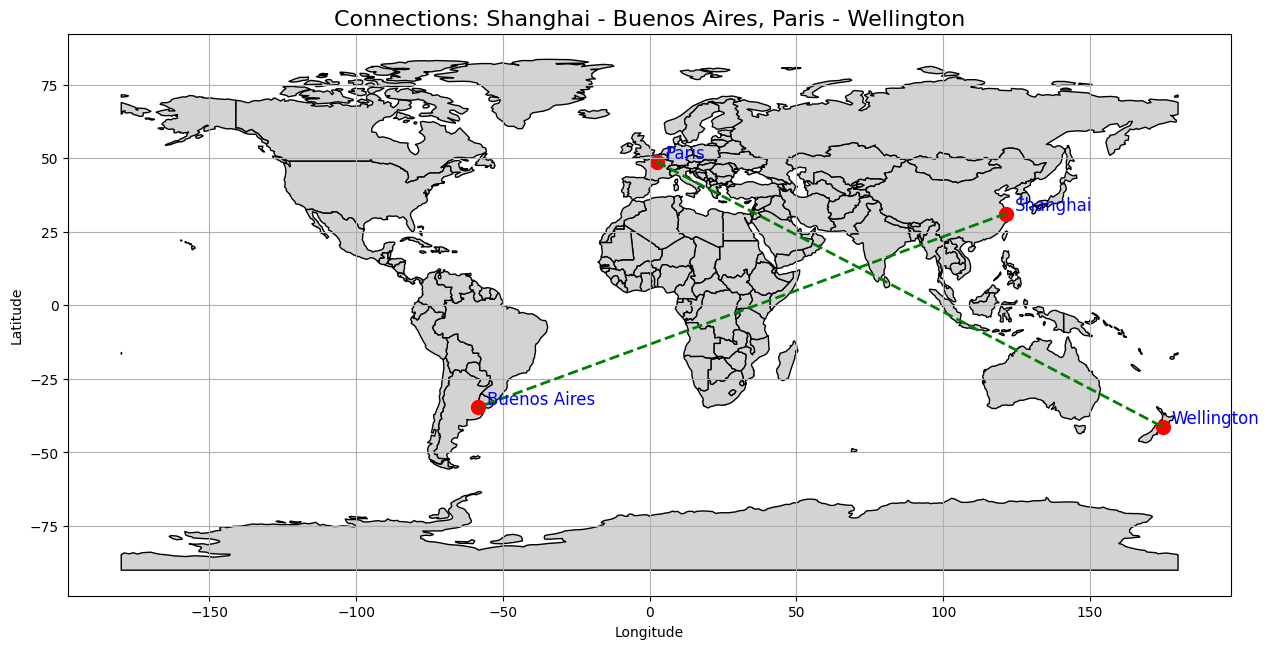

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")

city_coords = {
    "Shanghai": (121.4737, 31.2304),
    "Buenos Aires": (-58.3816, -34.6037),
    "Paris": (2.3522, 48.8566),
    "Wellington": (174.7762, -41.2865)
}

points = gpd.GeoDataFrame(
    {'city': list(city_coords.keys())},
    geometry=[Point(coord) for coord in city_coords.values()],
    crs="EPSG:4326"
)

lines = gpd.GeoDataFrame(
    geometry=[
        LineString([city_coords["Shanghai"], city_coords["Buenos Aires"]]),
        LineString([city_coords["Paris"], city_coords["Wellington"]])
    ],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(15, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')

points.plot(ax=ax, color='red', markersize=100)

for x, y, label in zip(points.geometry.x, points.geometry.y, points['city']):
    ax.text(x + 3, y + 1, label, fontsize=12, ha='left', color='blue')

lines.plot(ax=ax, color='green', linestyle='--', linewidth=2)

ax.set_title("Connections: Shanghai - Buenos Aires, Paris - Wellington", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.show()

### 19:Proposer une figure comparant l’impact carbone mensuel des missions en fonction du type de transport et sur chaque site.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as f

sdf_impact_mensuel = fait_mission.join(
    sdf_dimension_date, "ID_DATE"
).join(
    sdf_dimension_transport, "ID_TRANSPORT"
).join(
    sdf_dimension_site, "ID_SITE"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DEPART")
                           .withColumnRenamed("VILLE", "VILLE_DEPART")
                           .withColumnRenamed("PAYS", "PAYS_DEPART"), "ID_DEPART"
).join(
    sdf_dimension_location.withColumnRenamed("ID_LOCATION", "ID_DESTINATION")
                           .withColumnRenamed("VILLE", "VILLE_DESTINATION")
                           .withColumnRenamed("PAYS", "PAYS_DESTINATION"), "ID_DESTINATION"
)

sdf_impact_mensuel = sdf_impact_mensuel.select("SITE","ID_PERSONNEL","DATE","ALLER_RETOUR","TRANSPORT", "VILLE_DEPART", "PAYS_DEPART", "VILLE_DESTINATION", "PAYS_DESTINATION")

##renomer
sdf_impact_mensuel = sdf_impact_mensuel\
    .withColumnRenamed("TRANSPORT", "a_TRANSPORT") \
    .withColumnRenamed("VILLE_DEPART", "a_VILLE_DEPART") \
    .withColumnRenamed("PAYS_DEPART", "a_PAYS_DEPART") \
    .withColumnRenamed("VILLE_DESTINATION", "a_VILLE_DESTINATION") \
    .withColumnRenamed("PAYS_DESTINATION", "a_PAYS_DESTINATION")

sdf_impact_mensuel = sdf_impact_mensuel.join(
    sdf_final_mission_europe,
    (sdf_impact_mensuel["a_VILLE_DEPART"] == sdf_final_mission_europe["VILLE_DEPART"]) &
    (sdf_impact_mensuel["a_PAYS_DEPART"] == sdf_final_mission_europe["PAYS_DEPART"]) &
    (sdf_impact_mensuel["a_VILLE_DESTINATION"] == sdf_final_mission_europe["VILLE_DESTINATION"]) &
    (sdf_impact_mensuel["a_PAYS_DESTINATION"] == sdf_final_mission_europe["PAYS_DESTINATION"]) &
    (sdf_impact_mensuel["a_TRANSPORT"] == sdf_final_mission_europe["TRANSPORT"]),
    how="inner"
)

sdf_impact_mensuel = sdf_impact_mensuel.dropDuplicates()

from pyspark.sql import functions as f

sdf_impact_mensuel_grouped = sdf_impact_mensuel.withColumn(
    "YearMonth", f.date_format(f.col("DATE"), "yyyy-MM")
).groupBy(
    "SITE", "YearMonth"
).agg(
    f.sum("each_distance").alias("total_distance")
).orderBy("SITE", "YearMonth")


sdf_impact_mensuel_grouped.show(10, truncate=False)


+------+---------+------------------+
|SITE  |YearMonth|total_distance    |
+------+---------+------------------+
|berlin|2024-04  |359725.61878251587|
|berlin|2024-05  |5026830.331831165 |
|berlin|2024-06  |4810735.977218603 |
|berlin|2024-07  |4470041.265940498 |
|berlin|2024-08  |5029120.589148089 |
|berlin|2024-09  |4876597.609987654 |
|berlin|2024-10  |5081975.198092922 |
|berlin|2024-11  |2389637.2514982456|
|london|2024-04  |322332.86964270845|
|london|2024-05  |4505517.8291184725|
+------+---------+------------------+
only showing top 10 rows




Il y a 48 missions dans tous les sites entre le 1er mai 2024 et le 31 octobre 2024.


In [ ]:
from pyspark.sql import functions as f

sdf_impact_mensuel_paris = sdf_impact_mensuel_grouped.filter(f.col("SITE") == "paris")
                                                             
sdf_impact_mensuel_paris.show(5, truncate=False)

+-----+---------+-----------------+
|SITE |YearMonth|total_distance   |
+-----+---------+-----------------+
|paris|2024-04  |411011.2978337099|
|paris|2024-05  |4642875.779008304|
|paris|2024-06  |5079351.853539039|
|paris|2024-07  |4853498.33316922 |
|paris|2024-08  |5086591.849577383|
+-----+---------+-----------------+
only showing top 5 rows




Il y a 8 missions dans le site de Paris entre le 1er mai 2024 et le 31 octobre 2024.


In [129]:
from pyspark.sql import functions as f

sdf_impact_mensuel_berlin = sdf_impact_mensuel_grouped.filter(f.col("SITE") == "berlin")
                                                             
sdf_impact_mensuel_berlin.show(5, truncate=False)

+------+---------+------------------+
|SITE  |YearMonth|total_distance    |
+------+---------+------------------+
|berlin|2024-04  |359725.61878251587|
|berlin|2024-05  |5026830.331831165 |
|berlin|2024-06  |4810735.977218603 |
|berlin|2024-07  |4470041.265940497 |
|berlin|2024-08  |5029120.589148089 |
+------+---------+------------------+
only showing top 5 rows



In [130]:
from pyspark.sql import functions as f

sdf_impact_mensuel_losangeles = sdf_impact_mensuel_grouped.filter(f.col("SITE") == "losangeles")
                                                             
sdf_impact_mensuel_losangeles.show(5, truncate=False)

+----------+---------+------------------+
|SITE      |YearMonth|total_distance    |
+----------+---------+------------------+
|losangeles|2024-04  |283541.20781954814|
|losangeles|2024-05  |5108481.387358    |
|losangeles|2024-06  |4907871.27310136  |
|losangeles|2024-07  |5062282.2496514805|
|losangeles|2024-08  |5373238.355984596 |
+----------+---------+------------------+
only showing top 5 rows



In [132]:
from pyspark.sql import functions as f

sdf_impact_mensuel_newyork = sdf_impact_mensuel_grouped.filter(f.col("SITE") == "newyork")
                                                             
sdf_impact_mensuel_newyork.show(5, truncate=False)

+-------+---------+------------------+
|SITE   |YearMonth|total_distance    |
+-------+---------+------------------+
|newyork|2024-04  |557279.8092424708 |
|newyork|2024-05  |4731247.1908056475|
|newyork|2024-06  |4066648.733451103 |
|newyork|2024-07  |4881096.789975549 |
|newyork|2024-08  |4580809.201550994 |
+-------+---------+------------------+
only showing top 5 rows



In [133]:
from pyspark.sql import functions as f

sdf_impact_mensuel_london = sdf_impact_mensuel_grouped.filter(f.col("SITE") == "london")
                                                             
sdf_impact_mensuel_london.show(5, truncate=False)

+------+---------+------------------+
|SITE  |YearMonth|total_distance    |
+------+---------+------------------+
|london|2024-04  |322332.8696427084 |
|london|2024-05  |4505517.8291184725|
|london|2024-06  |4449597.01877739  |
|london|2024-07  |4331047.755202115 |
|london|2024-08  |4411373.395490621 |
+------+---------+------------------+
only showing top 5 rows



In [134]:
from pyspark.sql import functions as f

sdf_impact_mensuel_shanghai = sdf_impact_mensuel_grouped.filter(f.col("SITE") == "shanghai")
                                                             
sdf_impact_mensuel_shanghai.show(5, truncate=False)

+--------+---------+------------------+
|SITE    |YearMonth|total_distance    |
+--------+---------+------------------+
|shanghai|2024-04  |313724.34736080974|
|shanghai|2024-05  |3758303.926269629 |
|shanghai|2024-06  |3388985.8705166485|
|shanghai|2024-07  |3404200.9057048247|
|shanghai|2024-08  |2837377.5290508326|
+--------+---------+------------------+
only showing top 5 rows



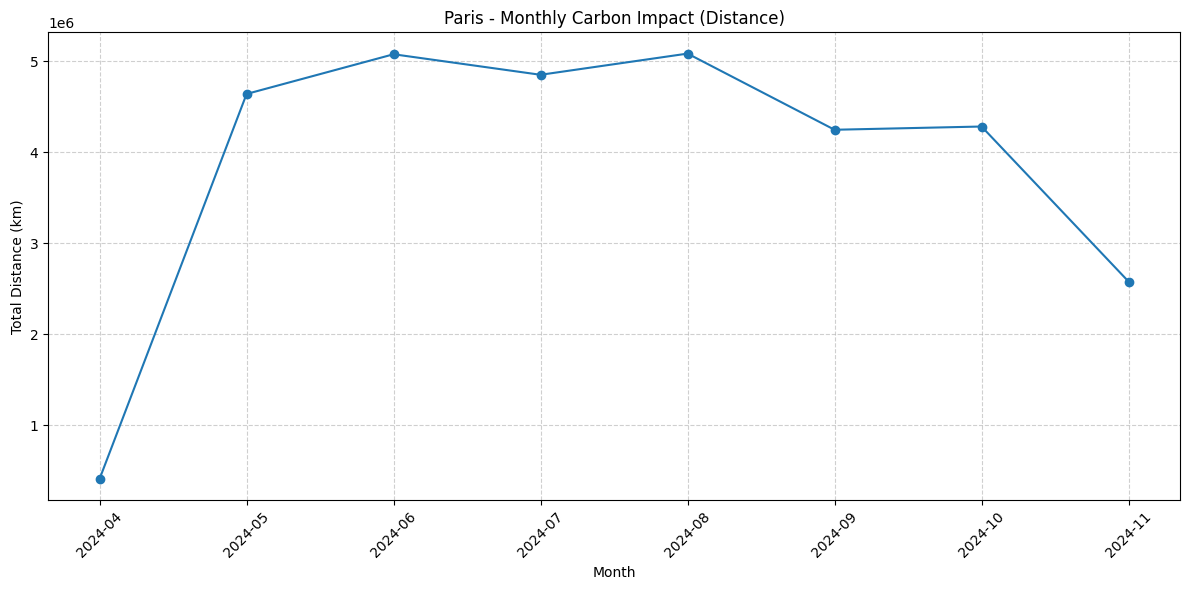

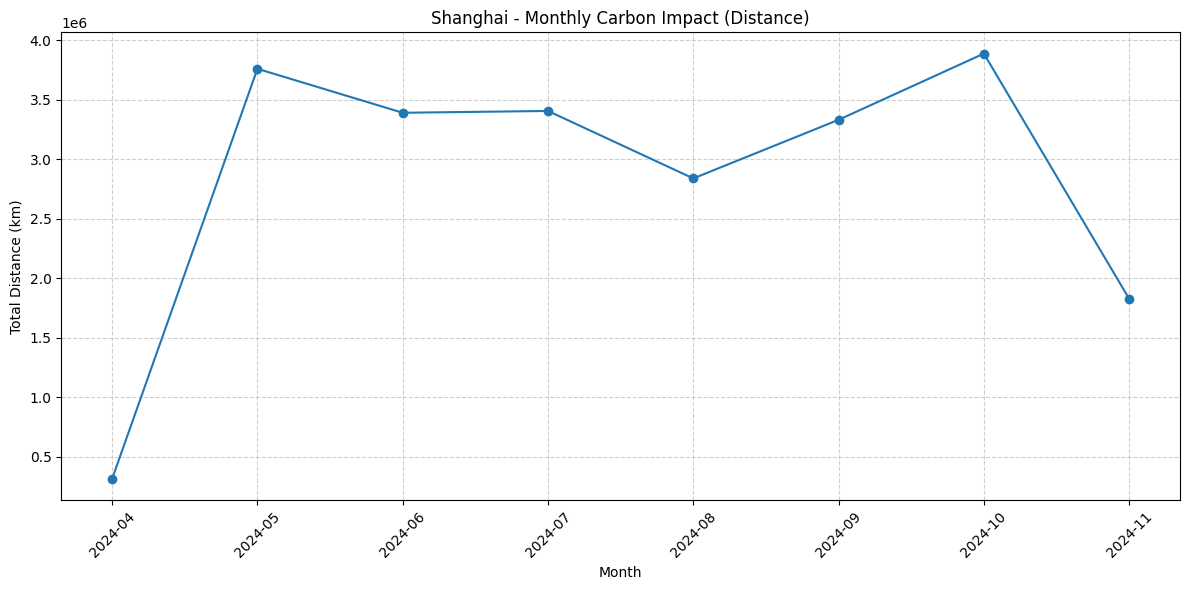

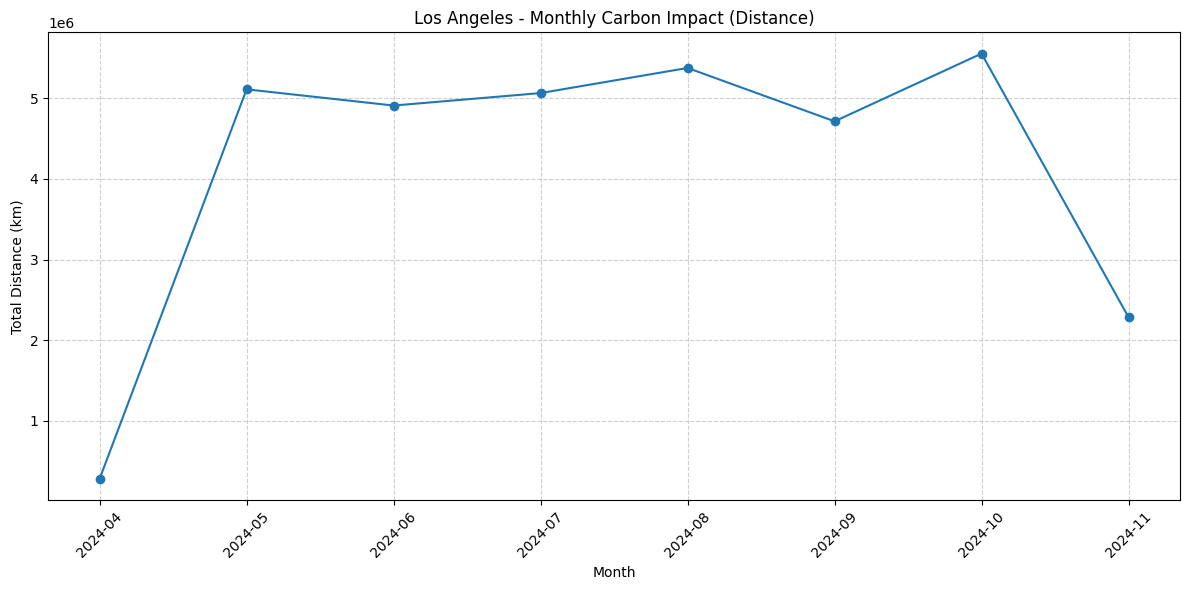

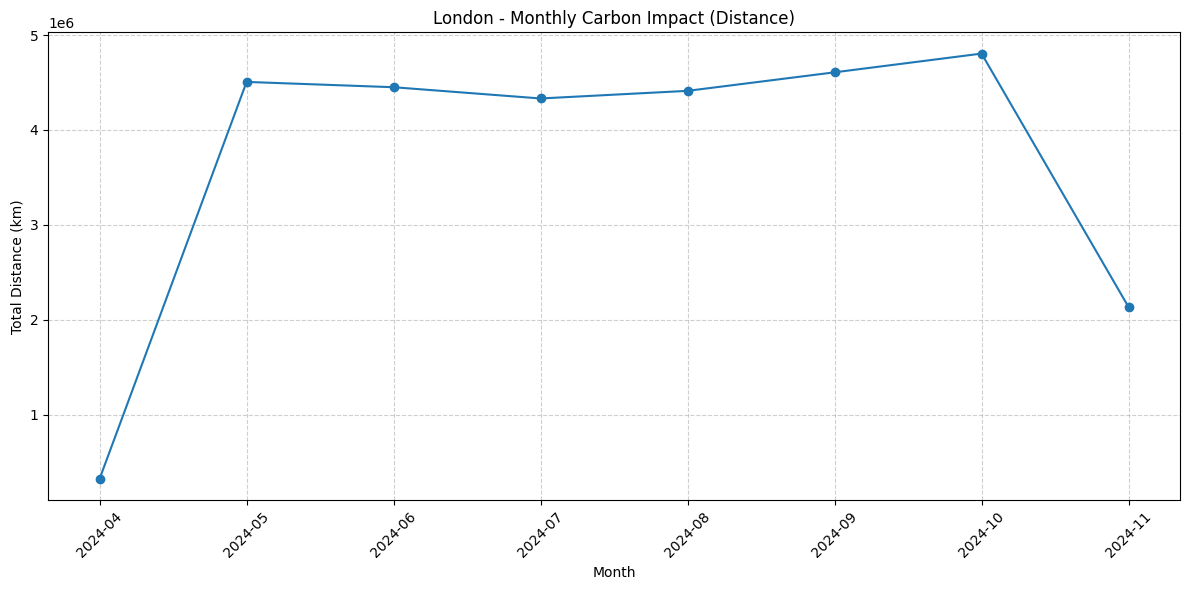

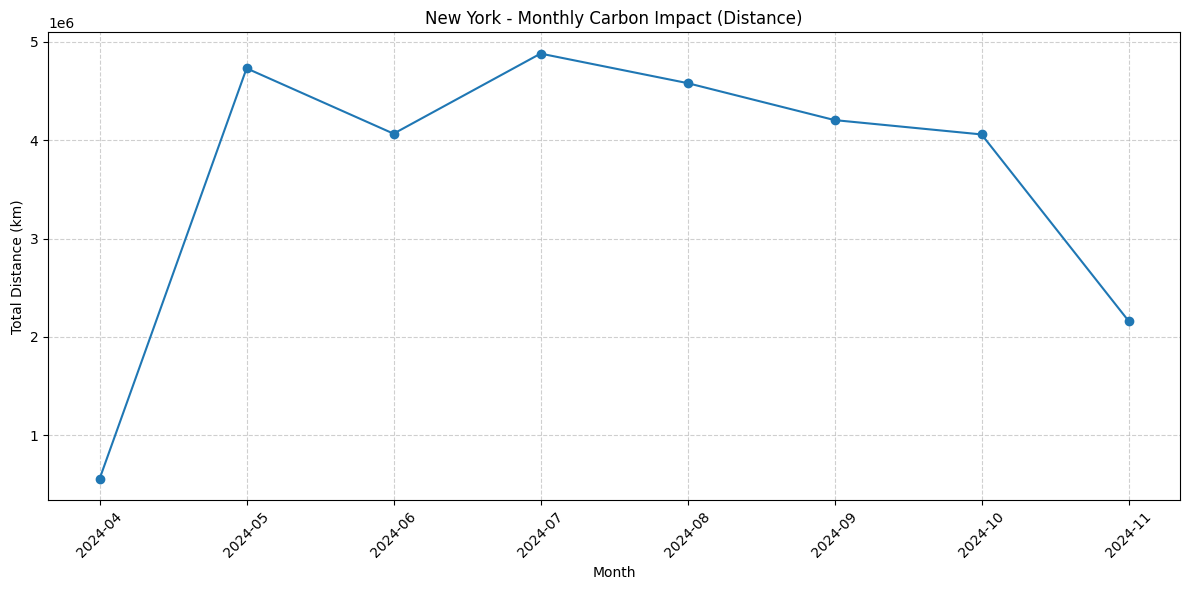

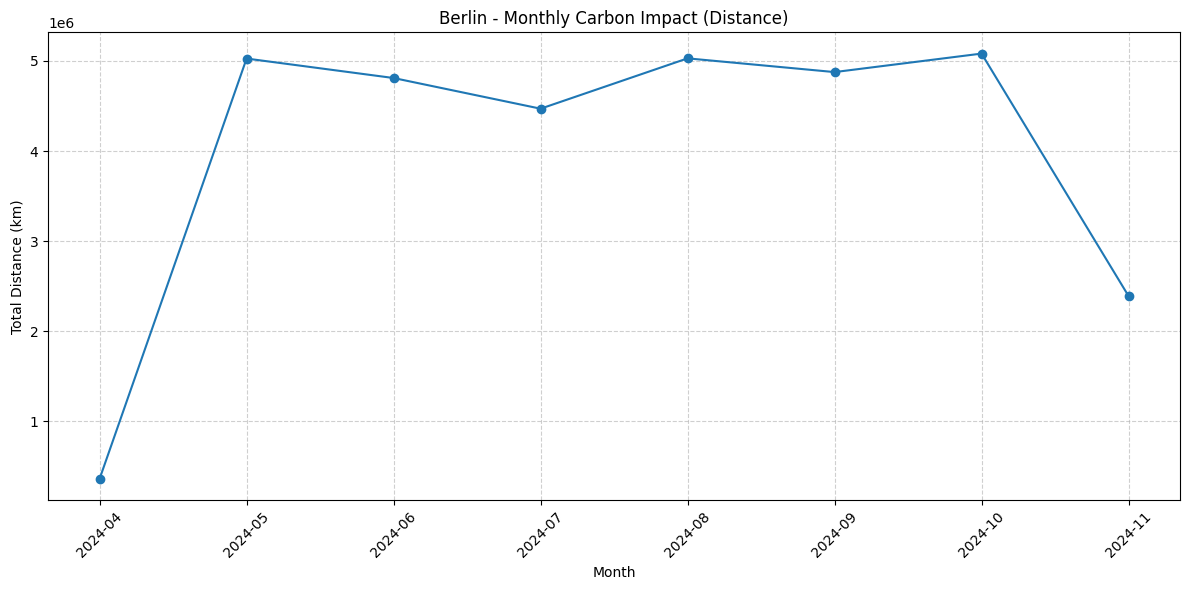

In [136]:
pdf_impact_mensuel_paris = sdf_impact_mensuel_paris.toPandas()
pdf_impact_mensuel_shanghai = sdf_impact_mensuel_shanghai.toPandas()
pdf_impact_mensuel_losangeles = sdf_impact_mensuel_losangeles.toPandas()
pdf_impact_mensuel_london = sdf_impact_mensuel_london.toPandas()
pdf_impact_mensuel_newyork = sdf_impact_mensuel_newyork.toPandas()
pdf_impact_mensuel_berlin = sdf_impact_mensuel_berlin.toPandas()


def plot_city_distance(df, city_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df["YearMonth"], df["total_distance"], marker='o')
    plt.title(f"{city_name} - Monthly Carbon Impact (Distance)")
    plt.xlabel("Month")
    plt.ylabel("Total Distance (km)")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_city_distance(pdf_impact_mensuel_paris, "Paris")
plot_city_distance(pdf_impact_mensuel_shanghai, "Shanghai")
plot_city_distance(pdf_impact_mensuel_losangeles, "Los Angeles")
plot_city_distance(pdf_impact_mensuel_london, "London")
plot_city_distance(pdf_impact_mensuel_newyork, "New York")
plot_city_distance(pdf_impact_mensuel_berlin, "Berlin")

### 20:Proposer une figure illustrant l’impact carbone global mensuel de l’organisation.

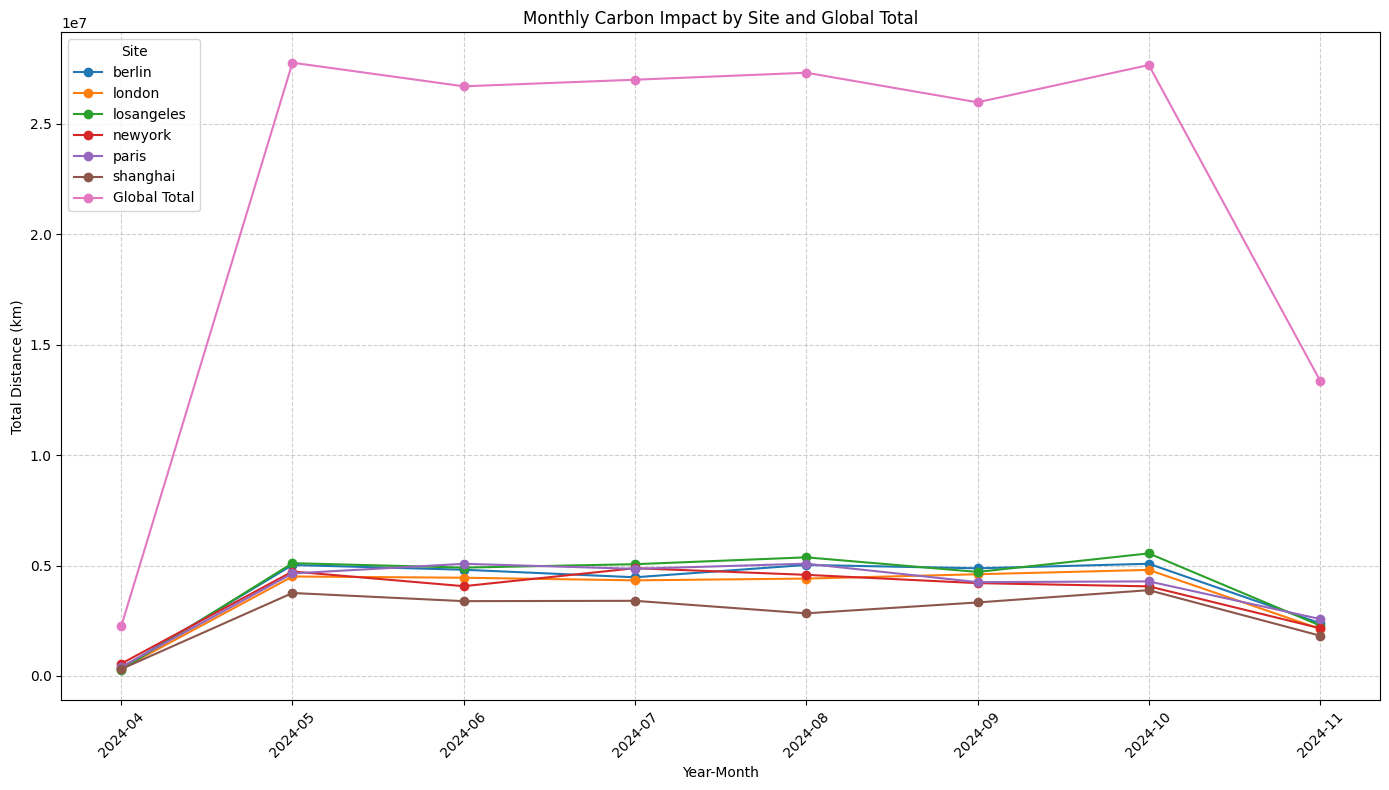

In [139]:
import matplotlib.pyplot as plt
import pandas as pd

pdf_impact_global = pd.concat([
    pdf_impact_mensuel_paris,
    pdf_impact_mensuel_shanghai,
    pdf_impact_mensuel_losangeles,
    pdf_impact_mensuel_london,
    pdf_impact_mensuel_newyork,
    pdf_impact_mensuel_berlin
])

pdf_impact_cities = pdf_impact_global.groupby(["SITE", "YearMonth"])["total_distance"].sum().reset_index()
pdf_impact_global_summary = pdf_impact_cities.groupby("YearMonth")["total_distance"].sum().reset_index()
pdf_impact_global_summary["SITE"] = "Global Total"

pdf_impact_combined = pd.concat([pdf_impact_cities, pdf_impact_global_summary])

plt.figure(figsize=(14, 8))

for site in pdf_impact_combined["SITE"].unique():
    site_data = pdf_impact_combined[pdf_impact_combined["SITE"] == site]
    plt.plot(site_data["YearMonth"], site_data["total_distance"], marker='o', label=site)

plt.title("Monthly Carbon Impact by Site and Global Total")
plt.xlabel("Year-Month")
plt.ylabel("Total Distance (km)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Site", loc="upper left")
plt.tight_layout()
plt.show()